In [2]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')


import os
os.environ["OMP_NUM_THREADS"] = "20"
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from umap import UMAP
from perturbseq import *

import scanpy as sc

import gseapy as gp
from gseapy import barplot,  dotplot

import re
from scipy.interpolate import interp1d
import math


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from hits.visualize import interactive
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Loading BokehJS ...

In [4]:
output_path = '/data/norman/southark/tfs_standardized/'

date = '20240318'

datasets = {'rpe1': 'RPE1_final_low_UMI_count_regressions_coef',
           'fibro': 'fibroblast_final_low_UMI_count_regressions_coef'}

In [6]:
low_pops = {}

low_pops['fibro_a']= CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240310_fibroblast_final_low_UMI_count_regressions_coef_mean_pop.hdf',
                                                        stored_matrix_ids=['p', 'adj_p', 'naive_mean_profile', 'count_profile'])


low_pops['rpe1_a']= CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240310_RPE1_final_low_UMI_count_regressions_coef_mean_pop.hdf',
                                                        stored_matrix_ids=['p', 'adj_p', 'naive_mean_profile', 'count_profile'])

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_count_profile', '/normalized_matrix_naive_mean_profile', '/normalized_matrix_p']
Loading metadata...
Done in 62.906222343444824s.
Done.
Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_count_profile', '/normalized_matrix_naive_mean_profile', '/normalized_matrix_p']
Loading metadata...
Done in 56.606809854507446s.
Done.


## Prep of the mean_pop.cells table and absolute expression reconstruction

In [7]:
low_pops['fibro_a'].cells['target_gene'] = low_pops['fibro_a'].cells.index.map(lambda x: x.split('_')[0])
low_pops['rpe1_a'].cells['target_gene'] = low_pops['rpe1_a'].cells.index.map(lambda x: x.split('_')[0])

### saving off-target guides

In [ ]:
fibro_offtarget = low_pops['fibro_a'].cells.query("target_gene == 'off-target'")
fibro_offtarget['Hs27'] = True

rpe1_offtarget = low_pops['rpe1_a'].cells.query("target_gene == 'off-target'")
rpe1_offtarget['RPE-1'] = True


off_target_guides = pd.merge(fibro_offtarget[['Hs27']], rpe1_offtarget[['RPE-1']], left_index = True, right_index = True, how = 'outer')

off_target_guides['protospacer'] = off_target_guides.index.str.split('_').str[-1]
off_target_guides[['protospacer','Hs27', 'RPE-1']].to_csv('off_target_guides.csv')

# Analysis Code

## Target Identification and mapping

In [8]:
import pandas as pd
import re

class GeneTargetAnalysis:
    def __init__(self, cell_population):
        self.cell_population = cell_population
        self.target_gene_dict = {}
        self.target_gene_info = None
        self.gene_id_guide_dict = {}

    def prepare_genes_of_interest(self):
        genes_of_interest = self.cell_population.cells['target_gene'].unique()
        genes_series = pd.Series(genes_of_interest).dropna()
        self.base_genes = genes_series.tolist()

    @staticmethod
    def find_related_genes(base_gene, var_names):
        pattern = '^' + re.escape(base_gene) + '[-.]'
        related_genes = [gene for gene in var_names if re.match(pattern, gene)]
        if base_gene in var_names:
            related_genes.append(base_gene)
        return related_genes

    def map_expressed_to_target_genes(self):
        self.target_gene_dict = {base_gene: self.find_related_genes(base_gene, self.cell_population.genes.gene_name.to_list()) 
                                 for base_gene in self.base_genes}

    def clean_empty_keys(self):
        empty_keys = [key for key, value in self.target_gene_dict.items() if not value]
        print("Genes with no values within the expression matrxi:", empty_keys)
        self.target_gene_dict = {key: value for key, value in self.target_gene_dict.items() if value}

    def select_variables_and_update_cells(self):
        all_related_genes = set(gene for genes in self.target_gene_dict.values() for gene in genes)
        selected_var = list(all_related_genes)

        self.target_gene_info = self.cell_population.genes.query('gene_name in @selected_var')
        self.cell_population.cells['target_gene_id'] = self.cell_population.cells.target_gene.map(self.target_gene_info.reset_index().set_index('gene_name')['gene_id'])
        self.target_gene_info.drop_duplicates(subset='gene_name', keep='first', inplace=True)

        self.target_gene_id_series = self.target_gene_info.reset_index().set_index('gene_name')['gene_id']

    def map_genes_to_guides(self):
        gene_to_guides = self.cell_population.cells.reset_index().groupby('target_gene')['guide_identity'].apply(list).to_dict()
        updated_target_gene_dict = {guide: self.target_gene_dict.get(gene, []) 
                                    for gene, guides in gene_to_guides.items() 
                                    for guide in guides}

        for key, gene_names_list in updated_target_gene_dict.items():
            gene_ids = [self.target_gene_id_series.get(gene_name) for gene_name in gene_names_list]
            self.gene_id_guide_dict[key] = gene_ids

    def run_analysis(self):
        self.prepare_genes_of_interest()
        self.map_expressed_to_target_genes()
        self.clean_empty_keys()
        self.select_variables_and_update_cells()
        self.map_genes_to_guides()
        return self.target_gene_info, self.gene_id_guide_dict

In [9]:
# analysis = GeneTargetAnalysis(mean_pop)
#target_gene_info, gene_id_guide_dict = analysis.run_analysis()

# Create interpolation of Expression Levels (Percentiles)

In [10]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

class PercentileExpressionAnalyzer:
    def __init__(self, cell_population):
        self.cell_population = cell_population

    @staticmethod
    def custom_round(value, threshold=0.01):
        if -threshold < value < threshold:
            return 0
        else:
            return value

    @staticmethod
    def calculate_percentile(value, distribution):
        return np.searchsorted(distribution, value, side='right') / len(distribution) * 100
    
    def reconstruct_expression(self):
        #expression reconstruction
        #Create Absolute Count Matrix
        #coefs are deviation from control, add control coefs to each gene to reconstruct absolute counts
        self.cell_population.normalized_matrix['reconstruction'] = self.cell_population.matrix + self.cell_population.matrix.loc['control'][self.cell_population.matrix.columns]
        self.cell_population.normalized_matrix['reconstruction'].loc['control'] = self.cell_population.matrix.loc['control'][self.cell_population.matrix.columns]

    def calculate_control_percentiles(self):
        # Assuming 'where' method or equivalent selection mechanism exists
        control_expression_raw_all = self.cell_population.where(cells='target_gene == "control"')
        control_expr_series_raw_all = control_expression_raw_all.T.sort_values('control', ascending=False)
        control_expr_series_raw_all = control_expr_series_raw_all['control'].apply(lambda x: self.custom_round(x, 0.001))
        control_means_mean_ordered = np.log10(control_expr_series_raw_all + 1e-6)

        max_value = control_means_mean_ordered.max()
        min_value = control_means_mean_ordered[control_means_mean_ordered > -6].min()
        num_points = 100000
        distribution = np.linspace(min_value, max_value, num_points)

        control_means_percentiles = control_means_mean_ordered.apply(lambda x: self.calculate_percentile(x, distribution=distribution))
        control_means_percentiles[control_means_mean_ordered == control_means_mean_ordered.min()] = 0

        # Remove duplicates
        unique_control_means, indices = np.unique(control_means_mean_ordered, return_inverse=True)
        averaged_percentiles = np.zeros_like(unique_control_means)
        for i, percentile in enumerate(control_means_percentiles):
            averaged_percentiles[indices[i]] += percentile
        averaged_percentiles /= np.bincount(indices)

        # Create interpolation function
        self.percentile_interpolator = interp1d(unique_control_means, averaged_percentiles, bounds_error=False, fill_value="extrapolate")
        # Predict control values
        self.predicted_control_percentiles = pd.Series(self.percentile_interpolator(control_means_mean_ordered), index=control_means_mean_ordered.index)

    def analyze_guides(self):
        all_guides_percentiles = {}
        for guide in self.cell_population.cells.query('cell_count > 1').index:
            guide_expression_raw_all = self.cell_population.normalized_matrix['reconstruction'].loc[guide]
            guide_expression_raw_all = guide_expression_raw_all.apply(lambda x: self.custom_round(x, 0.001))
            guide_expr_series_raw_all = np.log10(guide_expression_raw_all + 1e-6)

            # Apply the interpolation function
            predicted_percentiles = pd.Series(self.percentile_interpolator(guide_expr_series_raw_all), index=guide_expr_series_raw_all.index)
            all_guides_percentiles[guide] = predicted_percentiles

        # Create DataFrame from the dictionary and transpose it
        all_guides_percentiles_df = pd.DataFrame(all_guides_percentiles).T
        # Add control percentiles as a column
        all_guides_percentiles_df['control'] = self.predicted_control_percentiles

        # Store the transposed DataFrame in cell_population.normalized_matrix
        self.cell_population.normalized_matrix['pctl_expr'] = all_guides_percentiles_df


    def run(self):
        self.reconstruct_expression()
        self.calculate_control_percentiles()
        self.analyze_guides()
        return self.cell_population

In [11]:
# #mean_pop = # your CellPopulation instance
# analyzer = PercentileExpressionAnalyzer(mean_pop)
# mean_pop_pctl = analyzer.run()

# Create Final Results Table

In [12]:
import numpy as np
import pandas as pd

class GuideGeneAnalysis:
    def __init__(self, cell_population, gene_id_guide_dict, target_gene_info, fdr_threshold=0.1, non_expressed_threshold=10, count_threshold = 3):
        self.cell_population = cell_population
        self.gene_id_guide_dict =  gene_id_guide_dict
        self.target_gene_info = target_gene_info
        self.fdr_threshold = fdr_threshold
        self.non_expressed_threshold = non_expressed_threshold
        self.count_threshold = count_threshold
        self.results_df = None

    def analyze_percentiles(self):
        results_percentile = {}
        percentiles_df = self.cell_population.normalized_matrix['pctl_expr'].T

        for guide, genes in self.gene_id_guide_dict.items():
            if guide in percentiles_df.columns:
                for gene in genes:
                    if gene in percentiles_df.index:
                        control_percentile = percentiles_df.loc[gene, 'control']
                        target_percentile = percentiles_df.loc[gene, guide]
                        results_percentile[(guide, gene)] = {
                            'ctrl_pctl': control_percentile,
                            'target_pctl': target_percentile,
                        }
        self.results_df = pd.DataFrame.from_dict(results_percentile, orient='index')
        self._calculate_changes()
        self._add_extra_data()
        self._filter_and_rank()

    def _calculate_changes(self):
        # Debugging: Print available columns to check if 'target_pctl' and 'ctrl_pctl' exist
        print("Available columns in the DataFrame:", self.results_df.columns.tolist())

        # Check if 'target_pctl' and 'ctrl_pctl' exist in the DataFrame before accessing them
        if 'target_pctl' in self.results_df.columns and 'ctrl_pctl' in self.results_df.columns:
            self.results_df['pctl_change'] = self.results_df['target_pctl'] - self.results_df['ctrl_pctl']
            self.results_df['pctl_fc'] = self.results_df['target_pctl'] / self.results_df['ctrl_pctl']
            self.results_df['pctl_log2fc'] = np.log2((self.results_df['target_pctl'] / (self.results_df['ctrl_pctl'] + 1e-6)))
        else:
            print("Error: 'target_pctl' or 'ctrl_pctl' column not found in the DataFrame")

    def _add_extra_data(self):
        adj_p = self.cell_population.normalized_matrix.get('adj_p', pd.DataFrame())
        count_profile = self.cell_population.normalized_matrix.get('count_profile', pd.DataFrame())
        coefs = self.cell_population.matrix
        absolute = self.cell_population.normalized_matrix.get('reconstruction', pd.DataFrame())

        for index, row in self.results_df.iterrows():
            guide, gene = index

            # For adj_p, target_coef, target_abs, count_profile, and ctrl_count,
            # we check for KeyError due to guide-gene pair potentially not being present.
            self.results_df.at[index, 'adj_p'] = adj_p.loc[guide, gene] if (guide in adj_p.index and gene in adj_p.columns) else np.nan

            # For control coefficients and absolute values, assuming 'control' index always exists.
            self.results_df.at[index, 'ctrl_coef'] = coefs.loc['control', gene] if gene in coefs.columns else np.nan
            self.results_df.at[index, 'ctrl_abs'] = absolute.loc['control', gene] if gene in absolute.columns else np.nan

            # For target coefficients and absolute values, check if the guide-gene pair exists.
            self.results_df.at[index, 'target_coef'] = coefs.loc[guide, gene] if (guide in coefs.index and gene in coefs.columns) else np.nan
            self.results_df.at[index, 'target_abs'] = absolute.loc[guide, gene] if (guide in absolute.index and gene in absolute.columns) else np.nan

            # For count_profile and its control count, check if the guide-gene pair and control-gene pair exists.
            self.results_df.at[index, 'count_profile'] = count_profile.loc[guide, gene] if (guide in count_profile.index and gene in count_profile.columns) else np.nan
            self.results_df.at[index, 'ctrl_count'] = count_profile.loc['control', gene] if gene in count_profile.columns else np.nan

            
        self.results_df['ctrl_count_frac'] = self.results_df['ctrl_count']/self.cell_population.cells.cell_count.control
        self.results_df['gene_id'] = self.results_df.index.get_level_values(1)
        self.results_df['target_gene'] = self.results_df.gene_id.map(self.target_gene_info.gene_name)
        self.results_df['primary_target'] = self.results_df.index.get_level_values(level = 1).isin(self.cell_population.cells.target_gene_id.unique())
         # # Add a binary column 'is_expressed'
        self.results_df['ctrl_expressed'] = self.results_df.ctrl_pctl > self.non_expressed_threshold #control expression cutoff


    def _filter_and_rank(self):
        combined_filter = (self.results_df['pctl_change'] > 0) & (self.results_df['adj_p'] < self.fdr_threshold) & (self.results_df['count_profile'] >= self.count_threshold)
        self.results_df['is_activated'] = combined_filter
        
        # # Calculate the ranks based on 'target_pctl' for the combined filter
        combined_ranks = self.results_df.query('is_activated').groupby(level=1)['target_pctl'].rank(ascending=False, method='min')
        self.results_df['guide_rank'] = combined_ranks

        # Identify the top guide across both expressed and non-expressed
        top_guide_idx = self.results_df.query('is_activated').groupby(level=1)['target_pctl'].idxmax()
        #initiate top guide column
        self.results_df['top_guide'] = False
        self.results_df.loc[top_guide_idx, 'top_guide'] = True
        
        self.results_df['activation_expression'] = self.results_df.apply(self._categorize_actexp, axis=1)

    def _categorize_actexp(self, row):
        if row['is_activated'] and row['ctrl_pctl'] > self.non_expressed_threshold:
            return 'activated_exp'
        elif row['is_activated'] and row['ctrl_pctl'] <= self.non_expressed_threshold:
            return 'activated_nonexp'
        elif not row['is_activated'] and row['ctrl_pctl'] > self.non_expressed_threshold:
            return 'inactive_exp'
        else:
            return 'inactive_nonexp'

    def run(self):
        self.analyze_percentiles()
        # Return or further process self.results_df as needed
        return self.results_df

In [13]:
#set parameters
fdr = 0.1

#percentile cut off for calling expressed genes
non_expressed = 15

#number of droplets containing transcript
count_thres = 1


## Target Identification and mapping
mapping = {}
target_gene_info = {}
gene_id_guide_dict = {}


mapping['rpe1_a'] = GeneTargetAnalysis(low_pops['rpe1_a'])
target_gene_info['rpe1_a'], gene_id_guide_dict['rpe1_a'] = mapping['rpe1_a'].run_analysis()


mapping['fibro_a'] = GeneTargetAnalysis(low_pops['fibro_a'])
target_gene_info['fibro_a'], gene_id_guide_dict['fibro_a'] = mapping['fibro_a'].run_analysis()


# Create interpolation of Expression Levels (Percentiles)
analyzer = {}
pctl_pops = {}

analyzer['rpe1_a']= PercentileExpressionAnalyzer(low_pops['rpe1_a'])
pctl_pops['rpe1_a'] = analyzer['rpe1_a'].run()

analyzer['fibro_a']= PercentileExpressionAnalyzer(low_pops['fibro_a'])
pctl_pops['fibro_a'] = analyzer['fibro_a'].run()




# Create Final Results Tables
analysis = {}
results_df_percentile = {}

#run rpe1
analysis['rpe1_a'] = GuideGeneAnalysis(pctl_pops['rpe1_a'], gene_id_guide_dict['rpe1_a'], target_gene_info['rpe1_a'], 
                                       fdr_threshold=fdr, non_expressed_threshold=non_expressed, count_threshold = count_thres)
results_df_percentile['rpe1_a'] = analysis['rpe1_a'].run()


#run fibro
analysis['fibro_a'] = GuideGeneAnalysis(pctl_pops['fibro_a'], gene_id_guide_dict['fibro_a'], target_gene_info['fibro_a'], 
                                       fdr_threshold=fdr, non_expressed_threshold=non_expressed, count_threshold = count_thres)
results_df_percentile['fibro_a'] = analysis['fibro_a'].run()

Genes with no values within the expression matrxi: ['ANHX', 'ASCL3', 'ASCL4', 'BHLHA9', 'BHLHE22', 'BORCS8-MEF2B', 'CCDC169-SOHLH2', 'CDX4', 'DBX1', 'DMRTC1', 'DUX4', 'EBF3', 'EN2', 'EVX1', 'FERD3L', 'FOXA2', 'FOXB2', 'FOXI2', 'FOXR2', 'GSC2', 'HMGB4', 'HOXA13', 'HOXA1', 'HOXA9', 'HOXB1', 'HOXC12', 'HOXD12', 'HOXD1', 'HOXD9', 'HSFY1', 'HSFY2', 'INSM1', 'IRX1', 'KRBOX5', 'LHX8', 'LMX1A', 'MEIOSIN', 'MIDEAS', 'MSX2', 'MYF5', 'NEUROG1', 'NEUROG3', 'NKX1-1', 'NKX2-4', 'NKX6-3', 'NOBOX', 'PAX3', 'PEG3', 'POU3F4', 'PRDM9', 'RHOXF2B', 'RHOXF2', 'SALL1', 'SP8', 'SRY', 'TAFAZZIN', 'TBXT', 'TFDP3', 'TGIF2LX', 'TGIF2LY', 'TOX3', 'T', 'VAX1', 'ZIM2', 'ZNF286B', 'ZNF479', 'ZNF559-ZNF177', 'ZNF705B', 'ZNF705D', 'ZNF735', 'ZNF831', 'ZSCAN1', 'ZZZ3', 'control', 'off-target']


/tmp/ipykernel_714896/1742009850.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.target_gene_info.drop_duplicates(subset='gene_name', keep='first', inplace=True)


Genes with no values within the expression matrxi: ['ANHX', 'ASCL4', 'BARHL1', 'BORCS8-MEF2B', 'CCDC169-SOHLH2', 'CDX4', 'DMRTB1', 'DMRTC1', 'DMRTC2', 'DUX4', 'FERD3L', 'FOXB2', 'FOXI2', 'FOXR2', 'HOXD12', 'HSFX1', 'HSFX2', 'HSFY1', 'HSFY2', 'KRBOX5', 'LEUTX', 'MEIOSIN', 'MIDEAS', 'MYF5', 'NEUROD6', 'NKX2-4', 'NOBOX', 'NR5A1', 'OLIG3', 'POU3F4', 'PRDM9', 'RHOXF2B', 'SEBOX', 'SPIC', 'TAFAZZIN', 'TBX10', 'TGIF2LX', 'TGIF2LY', 'TPRX1', 'T', 'ZIC3', 'ZNF286B', 'ZNF479', 'ZNF559-ZNF177', 'ZNF705B', 'ZNF705D', 'ZNF705G', 'ZNF729', 'ZNF735', 'ZNF831', 'ZZZ3', 'control', 'off-target']


/tmp/ipykernel_714896/1742009850.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.target_gene_info.drop_duplicates(subset='gene_name', keep='first', inplace=True)
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Available columns in the DataFrame: ['ctrl_pctl', 'target_pctl']


/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Available columns in the DataFrame: ['ctrl_pctl', 'target_pctl']


/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
target_gene_info['fibro_a']

,gene_name,feature_types,genome,mean,in_matrix,std,cv,fano,pairwise_p_cost,mean_adjusted_pairwise_p_cost,excess_cv,pairwise_chosen
gene_id,,,,,,,,,,,,
ENSG00000001167,NFYA,Gene Expression,GRCh38,0.025891,True,0.162837,6.289360,1.024139,NaN,NaN,NaN,False
ENSG00000004848,ARX,Gene Expression,GRCh38,0.000078,True,0.009337,119.325806,1.114133,NaN,NaN,NaN,False
ENSG00000005073,HOXA11,Gene Expression,GRCh38,0.201061,True,0.467841,2.326858,1.088600,NaN,NaN,1.006737,False
ENSG00000005102,MEOX1,Gene Expression,GRCh38,0.000040,True,0.006687,166.160294,1.111033,NaN,NaN,NaN,False
ENSG00000005339,CREBBP,Gene Expression,GRCh38,0.384558,True,0.655758,1.705226,1.118215,NaN,NaN,1.000087,False
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000282728,PGR-AS1,Gene Expression,GRCh38,0.000002,True,0.001495,668.805420,0.999999,NaN,NaN,NaN,False
ENSG00000285278,TFAP2A-AS2,Gene Expression,GRCh38,0.005455,True,0.073946,13.555697,1.002383,NaN,NaN,NaN,False
ENSG00000285410,GABPB1-IT1,Gene Expression,GRCh38,0.127058,True,0.363933,2.864315,1.042418,NaN,NaN,NaN,False


In [15]:
target_gene_info['rpe1_a']

,gene_name,feature_types,genome,mean,in_matrix,std,cv,fano,pairwise_p_cost,mean_adjusted_pairwise_p_cost,excess_cv,pairwise_chosen
gene_id,,,,,,,,,,,,
ENSG00000001167,NFYA,Gene Expression,GRCh38,0.044581,True,0.214080,4.802032,1.028019,NaN,NaN,NaN,False
ENSG00000004848,ARX,Gene Expression,GRCh38,0.000533,True,0.023273,43.681278,1.016611,NaN,NaN,NaN,False
ENSG00000005073,HOXA11,Gene Expression,GRCh38,0.000159,True,0.012599,79.347107,0.999683,NaN,NaN,NaN,False
ENSG00000005102,MEOX1,Gene Expression,GRCh38,0.000106,True,0.010625,100.373039,1.066455,NaN,NaN,NaN,False
ENSG00000005339,CREBBP,Gene Expression,GRCh38,0.339129,True,0.614618,1.812342,1.113898,NaN,NaN,0.993108,False
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280927,CTBP1-AS,Gene Expression,GRCh38,0.004789,True,0.069183,14.445312,0.999373,NaN,NaN,NaN,False
ENSG00000285278,TFAP2A-AS2,Gene Expression,GRCh38,0.004760,True,0.069112,14.519589,1.003478,NaN,NaN,NaN,False
ENSG00000285410,GABPB1-IT1,Gene Expression,GRCh38,0.170481,True,0.424525,2.490166,1.057139,NaN,NaN,NaN,False


# Map phenotypic guide charactorization

In [17]:
#load cell pops with phenotype clustering
pops = dict()

pops['rpe1_a'] = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240309_RPE1_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
pops['fibro_a'] = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 3.647505044937134s.
Done.
Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 4.111606597900391s.
Done.


In [18]:
def analyze_guide_activity(population, results_df_percentile):
    # Extract guide_activity data
    guide_activity = population.cells.reset_index()[['guide_identity', 'active', 'masked_active', 'cluster_description', 'masked_cluster_description', 'bulk_expr', 'expressed', 'p_expressed', 'target_gene', 'cell_count']].copy()
    guide_activity = guide_activity.set_index(['guide_identity', 'target_gene'])
    guide_activity = guide_activity[~guide_activity.index.duplicated(keep='first')]
    
    # Prepare on_target_activity data
    on_target_activity = results_df_percentile.reset_index().rename(columns={'level_0': 'guide_identity', 'level_1': 'gene_name'}).set_index(['guide_identity', 'target_gene'])
    
    # Join guide_activity with on_target_activity
    on_target_and_pheno = on_target_activity.join(guide_activity)
    
    # Define mappings for categorical conversion
    masked_active_mapping = {True: "Active", False: "Inactive"}
    expressed_mapping = {True: "Expressed", False: "Not Expressed"}
    
    # Convert boolean columns to string categories
    on_target_and_pheno['masked_active_cat'] = on_target_and_pheno['masked_active'].map(masked_active_mapping)
    on_target_and_pheno['expressed_cat'] = on_target_and_pheno['expressed'].map(expressed_mapping)
    
    # Adjust the index and create a combined category
    on_target_and_pheno = on_target_and_pheno.reset_index(level=1)
    on_target_and_pheno['category'] = on_target_and_pheno['masked_active_cat'] + "_" + on_target_and_pheno['expressed_cat']
    
    return on_target_and_pheno

In [19]:
#apply to result_df
final = {}

final['rpe1_a'] = analyze_guide_activity(pops['rpe1_a'], results_df_percentile['rpe1_a'])
final['fibro_a'] = analyze_guide_activity(pops['fibro_a'], results_df_percentile['fibro_a'])

# Save Final Result

In [20]:
#save final result

#get dataset name string
datasets_r = datasets['rpe1']
datasets_f = datasets['fibro']

# final['rpe1_a'].to_csv(f'{output_path}/{date}_{datasets_r}_on_target_activation_percentile_phenotype.csv')
# final['fibro_a'].to_csv(f'{output_path}/{date}_{datasets_f}_on_target_activation_percentile_phenotype.csv')

# Save Pops with Percentile Interplolations for all genes

In [21]:
pctl_pops['fibro_a'].cells = pctl_pops['fibro_a'].cells.reset_index().merge(final['fibro_a'].reset_index(), 
                                               on = ['guide_identity','target_gene', 'cell_count'],
                                              how = 'left').set_index('guide_identity')


pctl_pops['rpe1_a'].cells = pctl_pops['rpe1_a'].cells.reset_index().merge(final['rpe1_a'].reset_index(), 
                                               on = ['guide_identity','target_gene', 'cell_count'],
                                              how = 'left').set_index('guide_identity')

In [22]:
#percentiles for every gene/expressed gene
#cell pop with pct matrix and guide annotations...

# pctl_pops['fibro_a'].to_hdf(f'{output_path}/{date}_{datasets_f}_percentile_expression_changes_all_genes.hdf', store_normalized_matrix =True)
# pctl_pops['rpe1_a'].to_hdf(f'{output_path}/{date}_{datasets_r}_percentile_expression_changes_all_genes.hdf', store_normalized_matrix=True)

In [23]:
#percentiles for every gene/expressed gene
#cell pop with pct matrix and guide annotations...
#all_guides_percentiles_df.to_csv(f'{output_path}/{date}_{dataset}_percentile_expression_changes_all_genes.csv')

# Load results from Files so no need to rerun

**TO DO**

In [24]:
#load files
#pctl_dfs
#guide activity

# Summerization of On Target Guide Activity

In [25]:
def print_significant_target_counts(df, fdr_threshold, count_threshold):
    sig_pos_coefs = df[(df['adj_p'] < fdr_threshold) & (df.target_coef > 0)]
    
    # Targets with significant positive coefficients and count_profile >= 1
    num_targets_sig_pos_coefs = len(sig_pos_coefs[sig_pos_coefs.count_profile >= 1].target_gene.unique())
    print(f"num targets with sig pos coefs: {num_targets_sig_pos_coefs}")
    
    # Targets with significant positive coefficients and count_profile >= 3
    num_targets_sig_pos_coefs_cp3 = len(sig_pos_coefs[sig_pos_coefs.count_profile >= count_threshold].target_gene.unique())
    print(f"num targets with sig pos coefs & count_profile >= {count_threshold}: {num_targets_sig_pos_coefs_cp3}")

# Assuming results_df_percentile1, results_df_percentile2, ... are your DataFrames
print("Activatable targets for RPE1:")
print_significant_target_counts(results_df_percentile['fibro_a'], fdr, count_thres)

print("Activatable targets for Fibroblasts:")
print_significant_target_counts(results_df_percentile['rpe1_a'], fdr, count_thres)
print('NOTE: this includes related genes')

Activatable targets for RPE1:
num targets with sig pos coefs: 1336
num targets with sig pos coefs & count_profile >= 1: 1336
Activatable targets for Fibroblasts:
num targets with sig pos coefs: 1357
num targets with sig pos coefs & count_profile >= 1: 1357
NOTE: this includes related genes


# Merge guide activity accross cell types

In [26]:
# Prepare the data
rpe1_primary = final['rpe1_a'][final['rpe1_a'].primary_target]
fibro_primary = final['fibro_a'][final['fibro_a'].primary_target]

rpe1_ot = rpe1_primary.reset_index().set_index(['guide_identity', 'gene_name'])
fibro_ot = fibro_primary.reset_index().set_index(['guide_identity', 'gene_name'])

guides_merged = pd.merge(fibro_ot, rpe1_ot, suffixes = ('_fibro', '_rpe1'),
                         left_index=True, right_index=True, how = 'outer')


guides_merged['target_gene_fibro'] = guides_merged['target_gene_fibro'].combine_first(guides_merged['target_gene_rpe1'])
guides_merged['target_gene_rpe1'] = guides_merged['target_gene_rpe1'].combine_first(guides_merged['target_gene_fibro'])


guides_merged['primary_target_fibro'] = guides_merged['primary_target_fibro'].combine_first(guides_merged['primary_target_rpe1'])
guides_merged['primary_target_rpe1'] = guides_merged['primary_target_rpe1'].combine_first(guides_merged['primary_target_fibro'])

guides_merged = guides_merged.rename(columns = {'target_gene_fibro': 'target_gene', 
                               'primary_target_fibro': 'primary_target'})

guides_merged = guides_merged.drop(columns = ['target_gene_rpe1','primary_target_rpe1'])

guides_merged['protospacer'] = guides_merged.index.get_level_values(0).str.split('_').str[1]

guides_merged.loc[guides_merged.activation_expression_fibro.isna(), 'activation_expression_fibro'] = 'dropout'
guides_merged.loc[guides_merged.activation_expression_rpe1.isna(), 'activation_expression_rpe1'] = 'dropout'

# Apply seed region classification

In [27]:
import dill

with open('/data/norman/southark/tfs_standardized/20240309_RPE1_CRISPRa_masked_variables.pickle', 'rb') as file:
    data = dill.load(file)

rpe1_seq_cluster_info = data['seq_cluster_info']

with open('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_masked_variables.pickle', 'rb') as file:
    data = dill.load(file)

fibro_seq_cluster_info = data['seq_cluster_info']

rpe1_seq_cluster_info['cluster_frac'] = rpe1_seq_cluster_info.cluster_size / rpe1_seq_cluster_info.total_sgRNAs_with_seed
fibro_seq_cluster_info['cluster_frac'] = fibro_seq_cluster_info.cluster_size / fibro_seq_cluster_info.total_sgRNAs_with_seed


seq_thresholds = pd.DataFrame([rpe1_seq_cluster_info['threshold'], fibro_seq_cluster_info['threshold'],]).T

seq_frac = pd.DataFrame([rpe1_seq_cluster_info['cluster_frac'], fibro_seq_cluster_info['cluster_frac'],]).T
remove_seeds_thres = seq_thresholds.mean(axis=1)[seq_thresholds.mean(axis=1) < seq_thresholds.mean(axis=1).quantile(0.3)]
remove_seeds_frac = seq_frac.mean(axis=1)[seq_frac.mean(axis=1) >seq_frac.mean(axis=1).quantile(0.3)]

remove_rank = seq_thresholds.rank().mean(axis=1).sort_values().head(75)

#get list of bad seeds
bad_seeds = remove_rank.index.str.split('_').str[1]

In [28]:
bad_seeds

Index(['TCCTG', 'CTGGAG', 'TGGAG', 'CGGCGG', 'ACAGAG', 'ATCCC', 'CCCCT',
       'GGGAG', 'AAGGGG', 'GGGGAG', 'GAGAG', 'CCCTG', 'CGAG', 'GGAGG',
       'TGTCCG', 'TGAGG', 'GGGGA', 'CTCTG', 'CGGGGA', 'AGACC', 'GAGGTG',
       'GAAGG', 'CCTG', 'AGCGG', 'GAG', 'GGCGG', 'GGAG', 'ACCTG', 'CAGAG',
       'GGG', 'TGGGG', 'ATCTG', 'TCCCG', 'CGGAAG', 'CTG', 'AGGGG', 'GACGG',
       'CCT', 'CACTG', 'CCG', 'GGGAA', 'ATGAG', 'GAGGG', 'AAGGG', 'CGGAG',
       'AGAGG', 'TGGGT', 'CCCGG', 'GGA', 'AGGTG', 'CGAGG', 'AAGAG', 'AGGGT',
       'GAGG', 'TCCG', 'GGAGA', 'GTCCG', 'TGGG', 'CCAGG', 'GAGGGG', 'GTG',
       'TAGAG', 'GGAAG', 'GAGTG', 'TGAG', 'CGGGG', 'GGGG', 'GGGTG', 'ACTG',
       'ACCCGG', 'AGGAG', 'CGGGA', 'CCC', 'GGGGG', 'CTGGA'],
      dtype='object')

Text(0.5, 1.0, 'Bad Seed Thresholds')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

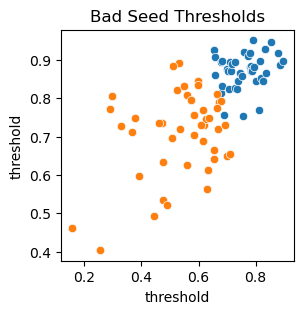

In [29]:
#thresholds of bad seeds accros cell type

plt.figure(figsize = (3,3))
sns.scatterplot(x = seq_thresholds.iloc[:,0], y =seq_thresholds.iloc[:,1])
sns.scatterplot(x = seq_thresholds.loc[remove_rank.index].iloc[:,0], y =seq_thresholds.iloc[:,1])
plt.title('Bad Seed Thresholds')

In [30]:
def match_and_record_end_of_strings(df, column_name, values_list):
    """
    For each string in the specified column of the DataFrame, check if the end of the string
    matches any of the strings in the values_list, where the length of the match is the length
    of the string from the list. Records the specific matches for each row.

    Args:
    df (pandas.DataFrame): The DataFrame to process.
    column_name (str): The name of the column containing strings.
    values_list (list of str): List of strings to match against the end of each string in the column.

    Returns:
    pandas.DataFrame: The original DataFrame with two new columns: 'matches' (boolean) and 'specific_matches' (list of strings).
    """
    match_flags = []
    specific_matches = []
    for row_string in df[column_name]:
        current_matches = [test_string for test_string in values_list if row_string.endswith(test_string)]
        match_flags.append(bool(current_matches))
        specific_matches.append(current_matches)

    df['bad_seed'] = match_flags
    df['seed_matches'] = specific_matches
    return df


In [31]:
guides_merged = match_and_record_end_of_strings(guides_merged, 'protospacer', bad_seeds)

In [32]:
activated_good_rpe1 = guides_merged[guides_merged.is_activated_rpe1 
              &guides_merged.primary_target 
              & ~guides_merged.bad_seed]#.sort_values('guide_rank_rpe1')#.drop_duplicates('target_gene')

activated_good_fibro = guides_merged[guides_merged.is_activated_fibro
              &guides_merged.primary_target 
              & ~guides_merged.bad_seed]#.sort_values('guide_rank_fibro')#.drop_duplicates('target_gene')

guides_merged['good_guide_fibro'] = np.where(guides_merged.index.isin(activated_good_fibro.index), True, False)
guides_merged['good_guide_rpe1'] = np.where(guides_merged.index.isin(activated_good_rpe1.index), True, False)

activated_best_rpe1 = guides_merged[guides_merged.is_activated_rpe1 
              &guides_merged.primary_target 
              & ~guides_merged.bad_seed].sort_values('guide_rank_rpe1').drop_duplicates('target_gene')

activated_best_fibro = guides_merged[guides_merged.is_activated_fibro
              &guides_merged.primary_target 
              & ~guides_merged.bad_seed].sort_values('guide_rank_fibro').drop_duplicates('target_gene')

guides_merged['best_guide_fibro'] = np.where(guides_merged.index.isin(activated_best_fibro.index), True, False)
guides_merged['best_guide_rpe1'] = np.where(guides_merged.index.isin(activated_best_rpe1.index), True, False)

In [33]:
good_in_both = len(guides_merged[guides_merged.good_guide_fibro&guides_merged.good_guide_rpe1&guides_merged.primary_target].target_gene.unique())

print(f'there are {good_in_both} unique targets where the good guide is shared across cell types')

at_least_1 = len(guides_merged[(guides_merged.good_guide_fibro|guides_merged.good_guide_rpe1)&guides_merged.primary_target].target_gene.unique())

print(f'there are {at_least_1} unique targets where the there is a good guide in at least 1 type')

#guides_merged['good_guide_either'] = np.where(guides_merged.good_guide_fibro|guides_merged.good_guide_rpe1, True, False)
#guides_merged['good_guide_both'] = np.where(guides_merged.good_guide_fibro&guides_merged.good_guide_rpe1, True, False)

there are 947 unique targets where the good guide is shared across cell types
there are 1409 unique targets where the there is a good guide in at least 1 type


In [34]:
guides_merged[guides_merged['good_guide_rpe1']].target_gene.describe()

count      3160
unique     1222
top       PRDM6
freq          6
Name: target_gene, dtype: object

In [35]:
guides_merged[guides_merged['good_guide_fibro']].target_gene.describe()

count     2870
unique    1198
top       RXRG
freq         6
Name: target_gene, dtype: object

In [36]:
guides_merged['seed_driven_fibro'] = guides_merged.masked_cluster_description_fibro.str.contains('SEQUENCE').fillna(False)
guides_merged['seed_driven_rpe1'] = guides_merged.masked_cluster_description_rpe1.str.contains('SEQUENCE').fillna(False)

In [37]:
guides_merged

,,target_gene,ctrl_pctl_fibro,target_pctl_fibro,pctl_change_fibro,pctl_fc_fibro,pctl_log2fc_fibro,adj_p_fibro,ctrl_coef_fibro,ctrl_abs_fibro,target_coef_fibro,...,category_rpe1,protospacer,bad_seed,seed_matches,good_guide_fibro,good_guide_rpe1,best_guide_fibro,best_guide_rpe1,seed_driven_fibro,seed_driven_rpe1
guide_identity,gene_name,,,,,,,,,,,,,,,,,,,,,
AATF_GCGCAGAAGGTTGAAGGGAT,ENSG00000275700,AATF,40.901,56.899427,15.998427,1.391150,0.476278,2.192302e-27,0.147171,0.147171,0.888691,...,Inactive_Expressed,GCGCAGAAGGTTGAAGGGAT,False,[],True,True,False,False,False,True
AATF_GCGTGCGAGTGCGCGGGAAG,ENSG00000275700,AATF,40.901,53.706380,12.805380,1.313082,0.392957,5.468301e-03,0.147171,0.147171,0.554561,...,Inactive_Expressed,GCGTGCGAGTGCGCGGGAAG,True,[GGAAG],False,False,False,False,False,False
AATF_GGAAGCGCGCAGAAGGTTGA,ENSG00000275700,AATF,40.901,62.571534,21.670534,1.529829,0.613370,1.026817e-08,0.147171,0.147171,1.921923,...,Inactive_Expressed,GGAAGCGCGCAGAAGGTTGA,False,[],True,True,True,True,False,False
AATF_GGAAGGGATTGGAGCCGTAT,ENSG00000275700,AATF,40.901,55.581004,14.680004,1.358916,0.442456,4.503703e-28,0.147171,0.147171,0.734871,...,Inactive_Expressed,GGAAGGGATTGGAGCCGTAT,False,[],True,True,False,False,False,False
AATF_GGGCGTTGCTAGCATGAAGG,ENSG00000275700,AATF,40.901,57.932096,17.031096,1.416398,0.502227,6.108165e-28,0.147171,0.147171,1.027846,...,Inactive_Expressed,GGGCGTTGCTAGCATGAAGG,True,[GAAGG],False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC_GCGAGCCGGACTCTACGCCG,ENSG00000070476,ZXDC,29.162,42.148044,12.986044,1.445307,0.531376,6.781131e-09,0.035157,0.035157,0.136196,...,Inactive_Expressed,GCGAGCCGGACTCTACGCCG,True,[CCG],False,False,False,False,False,False
ZXDC_GGCTGGGCTGACGTGACGTG,ENSG00000070476,ZXDC,29.162,12.212545,-16.949455,0.418783,-1.255726,9.999998e-01,0.035157,0.035157,-0.030710,...,Inactive_Expressed,GGCTGGGCTGACGTGACGTG,True,[GTG],False,False,False,False,False,False
ZXDC_GGGAGCGCCGGCACCTACGA,ENSG00000070476,ZXDC,29.162,36.037601,6.875601,1.235773,0.305413,9.999974e-01,0.035157,0.035157,0.046165,...,Inactive_Expressed,GGGAGCGCCGGCACCTACGA,False,[],False,True,False,True,False,False


In [38]:
#guides_merged.to_csv(f'/data/norman/southark/tfs_standardized/{date}_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv')
#guides_merged.to_csv(f'/data/norman/southark/tfs_standardized/{date}_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef_bad_seed_75.csv')

In [39]:
#load guide library to count expected targeting guides, total dropout
#all_guides = pd.read_csv('/data/norman/southark/guide_libraries/CRISPRa_guide_selection/final_selected/final_combined_paralogs_morf_CRISPRa_library_with_adapters.csv')

In [40]:
#save final merged guide list will all expected guides...
#keep seperate so that guides are not accedentially included 
##in analysis if not tested?

# Load Final Guide list from file

**TO DO**

# Plot active guide classifications

In [41]:
#load guide library to count expected targeting guides, total dropout

In [42]:
fibro_counts = pd.DataFrame()
fibro_counts['Activation/Expression'] = guides_merged.activation_expression_fibro
fibro_counts['cell type'] = 'Hs27'

rpe1_counts = pd.DataFrame()
rpe1_counts['Activation/Expression'] = guides_merged.activation_expression_rpe1
rpe1_counts['cell type'] = 'RPE1'

guide_counts = pd.concat([fibro_counts, rpe1_counts])

## Color Palette

1. #864D9E - A deep purplish hue.
2. #376ADC - A softened medium blue with reduced saturation.
3. #AE5981 - A muted pinkish-purple.
4. #5AC2B0 - A teal or turquoise-like color.
5. #D99828 - A golden yellow.
6. #528FF0 - A light blue shade.

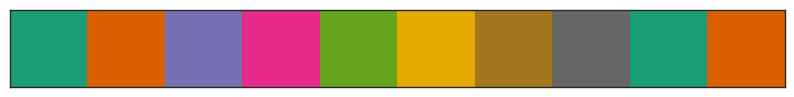

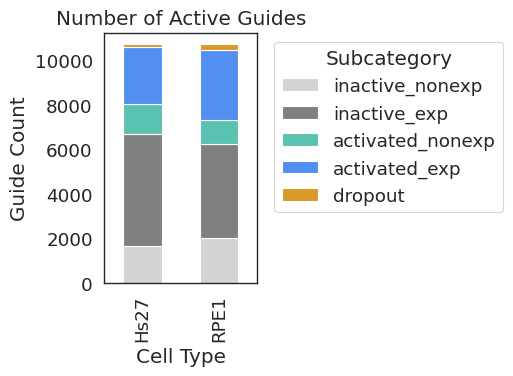

In [43]:
# Set Seaborn and Matplotlib settings for publication
sns.set(style="white", context="paper", font_scale=1.5)  # Adjust font_scale as needed

plt.rcParams['svg.fonttype'] = 'none'
#plt.rcParams['font.family'] = 'Arial'
# Preparing the data
# Count the occurrences of each Category/Subcategory combination
count_df = guide_counts.groupby(['cell type', 'Activation/Expression']).size().unstack(fill_value=0)

# Plotting
colors = ['#d3d3d3', '#808080', '#5AC2B0', '#528FF0', '#D99828']  # Updated colors list

sns.palplot(sns.color_palette("Dark2", 10))
sns.set_palette('Dark2')

# ## Color Palette

# 1. #864D9E - A deep purplish hue.
# 2. #376ADC - A softened medium blue with reduced saturation.
# 3. #AE5981 - A muted pinkish-purple.
# 4. #5AC2B0 - A teal or turquoise-like color.
# 5. #D99828 - A golden yellow.
# 6. #528FF0 - A light blue shade.
# 7. #ce6da1 - A pinkish red 
# 8. #'#d3d3d3', '#808080' #grays
# # Use this `colors` list in your plotting command as shown previously.


count_df[['inactive_nonexp', 'inactive_exp','activated_nonexp', 'activated_exp', 'dropout']].plot(
    kind='bar', stacked=True, figsize=(5.5,4), color = colors
)
plt.title('Number of Active Guides')
plt.xlabel('Cell Type')
plt.ylabel('Guide Count')

# Moving the legend to the right of the figure
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

#plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/num_active_guides_barplot.svg')

plt.show()

Median cell count: 131.0
Min cell count: 1.0
Max cell count: 1396.0


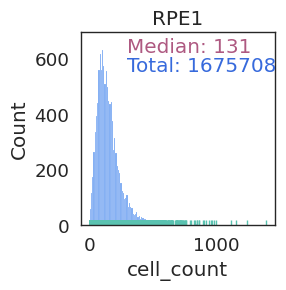

In [232]:
sns.set_context('paper', font_scale = 1.5)

#'#5AC2B0', '#528FF0', '#D99828'

rpe1_cells = pops['rpe1_a'].cells.query('target_gene != "off-target"')
plt.figure(figsize = (2.5,2.5))

sns.histplot(rpe1_cells.cell_count, color = '#528FF0')
sns.rugplot(rpe1_cells.cell_count, color = '#5AC2B0')

# Calculating the median
median_value = np.median(rpe1_cells.cell_count)
print("Median cell count:", median_value)

min_value = np.min(rpe1_cells.cell_count)
print("Min cell count:", min_value)

max_value = np.max(rpe1_cells.cell_count)
print("Max cell count:", max_value)

total_value = np.sum(rpe1_cells.cell_count)


# Adding text for the median on the plot
plt.text(x = plt.xlim()[1]*0.2, y=plt.ylim()[1]*0.9, s=f'Median: {int(median_value)}', color='#AE5981')
plt.text(x = plt.xlim()[1]*0.2, y=plt.ylim()[1]*0.8, s=f'Total: {int(total_value)}', color='#376ADC')

plt.title("RPE1")

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_guide_representation_rpe1.svg')

Median cell count: 59.0
Min cell count: 1.0
Max cell count: 689.0


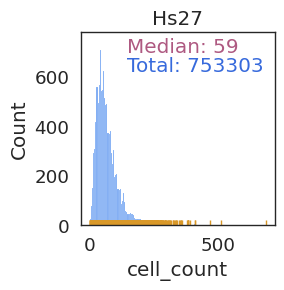

In [233]:
plt.figure(figsize = (2.5,2.5))

fibro_cells = pops['fibro_a'].cells.query('target_gene != "off-target"')

sns.histplot(fibro_cells.cell_count, color = '#528FF0')
sns.rugplot(fibro_cells.cell_count, color = '#D99828')
np.median(fibro_cells.cell_count)

# Calculating the median
median_value = np.median(fibro_cells.cell_count)
print("Median cell count:", median_value)

min_value = np.min(fibro_cells.cell_count)
print("Min cell count:", min_value)

max_value = np.max(fibro_cells.cell_count)
print("Max cell count:", max_value)

total_value = np.sum(fibro_cells.cell_count)

# Adding text for the median on the plot
plt.text(x = plt.xlim()[1]*0.2, y=plt.ylim()[1]*0.9, s=f'Median: {int(median_value)}', color='#AE5981')
plt.text(x = plt.xlim()[1]*0.2, y=plt.ylim()[1]*0.8, s=f'Total: {int(total_value)}', color='#376ADC')

plt.title("Hs27")

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_guide_representation_fibro.svg')

Median cell count: 866.0
Min cell count: 151.0
Max cell count: 3254.0


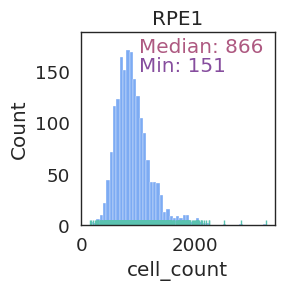

In [234]:
plt.figure(figsize = (2.5,2.5))

rpe1_targets = rpe1_cells.groupby('target_gene').cell_count.sum()

sns.histplot(rpe1_targets, color = '#528FF0')
sns.rugplot(rpe1_targets, color = '#5AC2B0')

# Calculating the median
median_value = np.median(rpe1_targets)
print("Median cell count:", median_value)

min_value = np.min(rpe1_targets)
print("Min cell count:", min_value)

max_value = np.max(rpe1_targets)
print("Max cell count:", max_value)

total_value = np.sum(rpe1_targets)


# Adding text for the median on the plot
plt.text(x = plt.xlim()[1]*0.3, y=plt.ylim()[1]*0.9, s=f'Median: {int(median_value)}', color='#AE5981')
plt.text(x = plt.xlim()[1]*0.3, y=plt.ylim()[1]*0.8, s=f'Min: {int(min_value)}', color='#864D9E')

plt.title("RPE1")

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_target_representation_rpe1.svg')

Median cell count: 387.0
Min cell count: 57.0
Max cell count: 1320.0


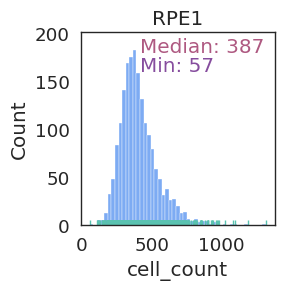

In [235]:
plt.figure(figsize = (2.5,2.5))

fibro_targets = fibro_cells.groupby('target_gene').cell_count.sum()

sns.histplot(fibro_targets, color = '#528FF0')
sns.rugplot(fibro_targets, color = '#5AC2B0')

# Calculating the median
median_value = np.median(fibro_targets)
print("Median cell count:", median_value)

min_value = np.min(fibro_targets)
print("Min cell count:", min_value)

max_value = np.max(fibro_targets)
print("Max cell count:", max_value)

total_value = np.sum(fibro_targets)


# Adding text for the median on the plot
plt.text(x = plt.xlim()[1]*0.3, y=plt.ylim()[1]*0.9, s=f'Median: {int(median_value)}', color='#AE5981')
plt.text(x = plt.xlim()[1]*0.3, y=plt.ylim()[1]*0.8, s=f'Min: {int(min_value)}', color='#864D9E')

plt.title("RPE1")

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_target_representation_fibro.svg')

In [417]:
library_qc = pd.read_csv('../240420_crispra_tfs_libqc_counts.csv')

In [418]:
len(library_qc.id.unique())

10900

Median cell count: 1.0
Min cell count: 0.0223642172523961
Max cell count: 6.931309904153355


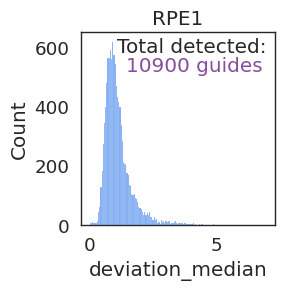

In [419]:
plt.figure(figsize = (2.5,2.5))

lib_counts = library_qc['deviation_median']

sns.histplot(lib_counts, color = '#528FF0')
#sns.rugplot(lib_counts, color = '#5AC2B0')

# Calculating the median
median_value = np.median(lib_counts)
print("Median cell count:", median_value)

min_value = np.min(lib_counts)
print("Min cell count:", min_value)

max_value = np.max(lib_counts)
print("Max cell count:", max_value)

total_value = np.sum(lib_counts > 0)


# Adding text for the median on the plot
plt.text(x = plt.xlim()[1]*0.15, y=plt.ylim()[1]*0.9, s='Total detected:')
plt.text(x = plt.xlim()[1]*0.2, y=plt.ylim()[1]*0.8, s=f'{int(total_value)} guides', color='#864D9E')

plt.title("RPE1")

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240420_tf_library_representation.svg')

Median cell count: 1.0
Min cell count: 0.5191693290734825
Max cell count: 3.2595846645367414


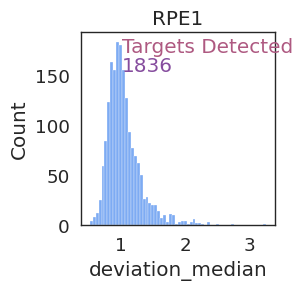

In [410]:
plt.figure(figsize = (2.5,2.5))

lib_targets = library_qc.groupby('gene')['deviation_median'].median()

sns.histplot(lib_targets, color = '#528FF0')
#sns.rugplot(lib_targets, color = '#5AC2B0')

# Calculating the median
median_value = np.median(lib_targets)
print("Median cell count:", median_value)

min_value = np.min(lib_targets)
print("Min cell count:", min_value)

max_value = np.max(lib_targets)
print("Max cell count:", max_value)

total_value = np.sum(lib_targets > 0)


# Adding text for the median on the plot
plt.text(x = plt.xlim()[1]*0.3, y=plt.ylim()[1]*0.9, s=f'Targets Detected', color='#AE5981')
plt.text(x = plt.xlim()[1]*0.3, y=plt.ylim()[1]*0.8, s=f'{int(total_value)}', color='#864D9E')

plt.title("RPE1")

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240419_target_representation_library.svg')

In [408]:
library_qc.drop_duplicates()

,Unnamed: 0,id,gene,protospacer,full_sequence,count,library,expected_counts,expected_median,deviation,deviation_median
0,0,AATF_GGAAGCGCGCAGAAGGTTGA,AATF,GGAAGCGCGCAGAAGGTTGA,agtatcccttggagaaccaccttgttgGGAAGCGCGCAGAAGGTTG...,479,True,708.387813,626.0,0.676183,0.765176
1,1,AATF_GCGTGCGAGTGCGCGGGAAG,AATF,GCGTGCGAGTGCGCGGGAAG,agtatcccttggagaaccaccttgttgGCGTGCGAGTGCGCGGGAA...,681,True,708.387813,626.0,0.961338,1.087859
2,2,AATF_GCGCAGAAGGTTGAAGGGAT,AATF,GCGCAGAAGGTTGAAGGGAT,agtatcccttggagaaccaccttgttgGCGCAGAAGGTTGAAGGGA...,594,True,708.387813,626.0,0.838524,0.948882
3,3,AATF_GGGCGTTGCTAGCATGAAGG,AATF,GGGCGTTGCTAGCATGAAGG,agtatcccttggagaaccaccttgttgGGGCGTTGCTAGCATGAAG...,541,True,708.387813,626.0,0.763706,0.864217
4,4,AATF_GTGAAGGGATTGGAGCCGTA,AATF,GTGAAGGGATTGGAGCCGTA,agtatcccttggagaaccaccttgttgGTGAAGGGATTGGAGCCGT...,540,True,708.387813,626.0,0.762294,0.862620
...,...,...,...,...,...,...,...,...,...,...,...
10892,10896,ZXDC_GGGGGCGCCGGGACCGACTA,ZXDC,GGGGGCGCCGGGACCGACTA,agtatcccttggagaaccaccttgttgGGGGGCGCCGGGACCGACT...,1363,True,708.387813,626.0,1.924087,2.177316
10893,10897,ZXDC_GGCTGGGCTGACGTGACGTG,ZXDC,GGCTGGGCTGACGTGACGTG,agtatcccttggagaaccaccttgttgGGCTGGGCTGACGTGACGT...,668,True,708.387813,626.0,0.942986,1.067093
10894,10898,ZZZ3_GCCCGCCACGGCACTTGCTC,ZZZ3,GCCCGCCACGGCACTTGCTC,agtatcccttggagaaccaccttgttgGCCCGCCACGGCACTTGCT...,1150,True,708.387813,626.0,1.623405,1.837061
10895,10899,ZZZ3_GGCTTCCACTAGACCCAACA,ZZZ3,GGCTTCCACTAGACCCAACA,agtatcccttggagaaccaccttgttgGGCTTCCACTAGACCCAAC...,782,True,708.387813,626.0,1.103915,1.249201


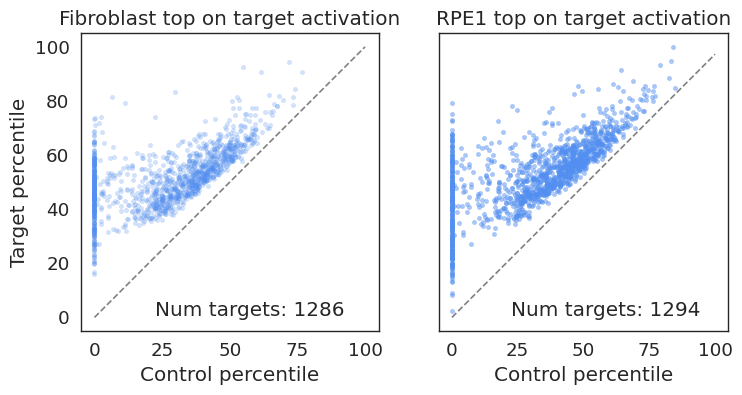

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the font to Arial for all Matplotlib figures
plt.rcParams['font.family'] = 'Arial'
# Alternatively, if 'Arial' is not directly recognized, use the following:
#plt.rcParams['font.sans-serif'] = 'Arial'


# Set Seaborn and Matplotlib settings for publication
sns.set(style="white", context="paper", font_scale=1.5)  # Adjust font_scale as needed

# Assuming final['rpe1_a'] and final['fibro_a'] are prepared DataFrame
rpe1_a_analysis = final['rpe1_a']
fibro_primary = final['fibro_a']

top_rpe1 = rpe1_a_analysis[rpe1_a_analysis.top_guide&rpe1_a_analysis.primary_target]
top_fibro = fibro_primary[fibro_primary.top_guide&fibro_primary.primary_target]

# Calculate the number of unique targets for each analysis
num_targets_rpe1_a = len(top_rpe1['target_gene'].unique())
num_targets_fibro_a = len(top_fibro['target_gene'].unique())


# Set the size of the entire figure
plt.figure(figsize=(8, 4))

# First subplot for rpe1_a
plt.subplot(1, 2, 1, aspect = 'equal')  # (rows, columns, panel number)
sns.scatterplot(data=top_fibro, x='ctrl_pctl', y='target_pctl',s =10, color = "#528FF0",
                alpha=0.25, #hue='pctl_change', hue_norm=(0, 30), 
                edgecolor=None)
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray', linestyle='--')  # 1:1 line
plt.title('Fibroblast top on target activation')
plt.xlabel('Control percentile')
plt.ylabel('Target percentile')
# Add text label for the number of targets
plt.text(0.25, 0.1, f'Num targets: {num_targets_fibro_a}', transform=plt.gca().transAxes, verticalalignment='top')



# Second subplot for fibro_a
plt.subplot(1, 2, 2, aspect = 'equal')
sns.scatterplot(data=top_rpe1, x='ctrl_pctl', y='target_pctl', s = 10, color = "#528FF0",
                alpha=0.5, #hue='pctl_change', hue_norm=(0, 30), 
                edgecolor=None)
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray', linestyle='--')  # 1:1 line
plt.title('RPE1 top on target activation')
plt.xlabel('Control percentile')
# Add text label for the number of targets
plt.text(0.25, 0.1, f'Num targets: {num_targets_rpe1_a}', transform=plt.gca().transAxes, verticalalignment='top')

plt.ylabel('')
plt.gca().yaxis.set_ticklabels([])  # Remove y-axis tick labels for the second plot

# Adjust layout to make room for plot titles, labels, etc.
plt.tight_layout()

# Optionally, save the figure to a file
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/top_guide_primary_target_on_target_activation_both_figure.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [249]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240410_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef_wGuide_labels.csv', index_col=0)

In [250]:
expressed_tfs = len(guide_library.query("(primary_target == True) & (ctrl_pctl_fibro >= 35)").target_gene.unique())

activated_expressed = len(guide_library.query("(primary_target == True) & (ctrl_pctl_fibro >= 35) & ((is_activated_fibro == True)|masked_active|expanded_masked_active)").target_gene.unique())

activated_expressed/expressed_tfs

0.809375

In [251]:
expressed_tfs = len(guide_library.query("(primary_target == True) & (expressed_fibro == True)").target_gene.unique())

activated_expressed = len(guide_library.query("(primary_target == True) & (expressed_fibro == True) & ((is_activated_fibro == True)|masked_active|expanded_masked_active)").target_gene.unique())

activated_expressed/expressed_tfs

0.7171197648787656

In [252]:
expressed_tfs

1361

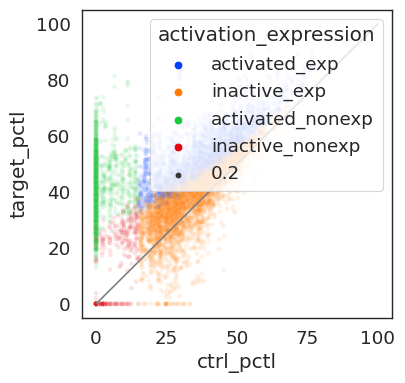

In [255]:
#single cell-type fibro
sns.set_context('paper', font_scale = 1.5)

plt.figure(figsize=(4, 4))

sns.scatterplot(data=fibro_primary, x='ctrl_pctl', y='target_pctl',
                 size=0.2, alpha=0.1, hue='activation_expression', palette = 'bright')


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/fibroblast_guide_activity_cat.pdf')

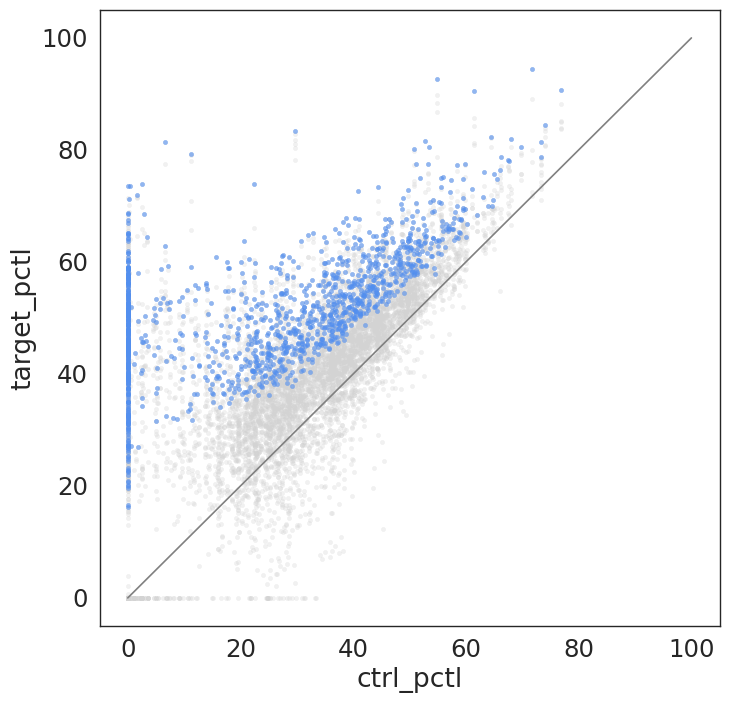

In [256]:
#single cell-type rpe1
sns.set_context('paper', font_scale = 2)
plt.figure(figsize=(8, 8))


sns.scatterplot(data=fibro_primary.query('primary_target == True'), x='ctrl_pctl', y='target_pctl',
                 s = 10, alpha=0.3, 
                color='#d3d3d3', edgecolor = None
               )

sns.scatterplot(data=top_fibro, x='ctrl_pctl', y='target_pctl',s =10, color = "#528FF0",
                alpha=0.6, #hue='pctl_change', hue_norm=(0, 30), 
                edgecolor=None)

# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')


plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_all_guides_and_top_guides_fibroblasts.svg')

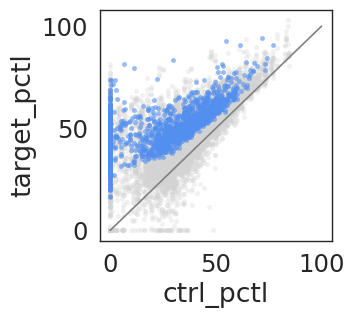

In [257]:
#single cell-type rpe1
sns.set_context('paper', font_scale = 2)
plt.figure(figsize=(3, 3))


sns.scatterplot(data=rpe1_primary.query('primary_target == True'), x='ctrl_pctl', y='target_pctl',
                 s = 10, alpha=0.3, 
                color='#d3d3d3', edgecolor = None
               )

sns.scatterplot(data=top_fibro, x='ctrl_pctl', y='target_pctl',s =10, color = "#528FF0",
                alpha=0.6, #hue='pctl_change', hue_norm=(0, 30), 
                edgecolor=None)

# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')


plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_all_guides_and_top_guides_rpe1.svg')

In [259]:
# df = fibro_primary.query('primary_target == True').fillna(0)


# df['target_pctl'] = df.target_pctl.astype("float")
# df['ctrl_pctl'] = df.ctrl_pctl.astype("float")


# # Assuming df is your DataFrame
# df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf/-inf with NaN
# df.fillna(0, inplace=True)  # Drop rows with NaN values

# interactive.scatter(df,
#                     initial_xy_names=['ctrl_pctl','target_pctl'],
#                     zoom_to_initial_data=True)

<Figure size 800x800 with 0 Axes>

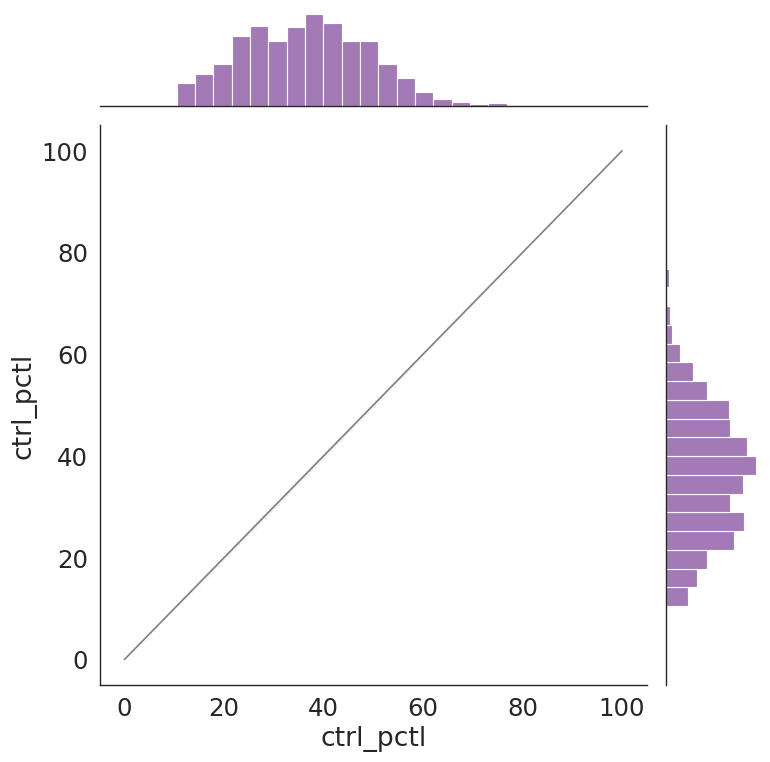

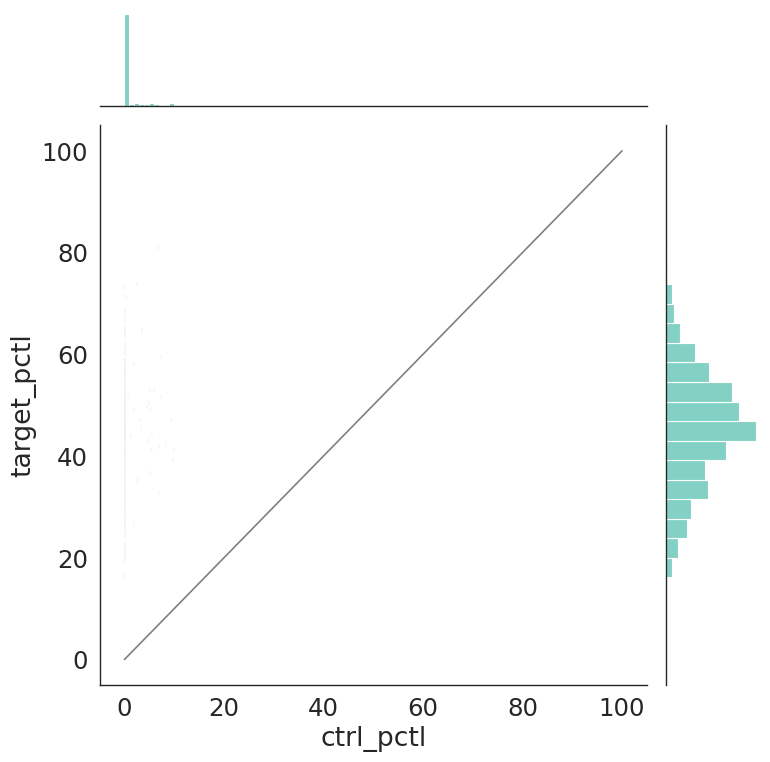

In [260]:
#single cell-type rpe1
plt.figure(figsize=(8, 8))


sns.jointplot(data=top_fibro.query('ctrl_pctl > 10'), x='ctrl_pctl', y='ctrl_pctl',
                # s = 10, 
              alpha=0.1, 
              height = 8,
                color='#864D9E', edgecolor = None, 
              kind = 'hist',
               bins = 100
               )


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_all_guides_and_top_guides_fibroblasts_control_hist.svg')

# sns.jointplot(data=fibro_primary.drop_duplicates(['target_pctl','pctl_change']), x='ctrl_pctl', y='target_pctl',
#                  s = 10, alpha=0.3, 
#                 color='#d3d3d3', edgecolor = None
#                )


sns.jointplot(data=top_fibro.query('ctrl_pctl < 10'), x='ctrl_pctl', y='target_pctl',
              #s =10, 
              color = "#5AC2B0",
              height = 8,
                alpha=0.1, #hue='pctl_change', hue_norm=(0, 30), 
              bins = 100, kind = 'hist',
                edgecolor=None)


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_all_guides_and_top_guides_fibroblasts_target_hist.svg')

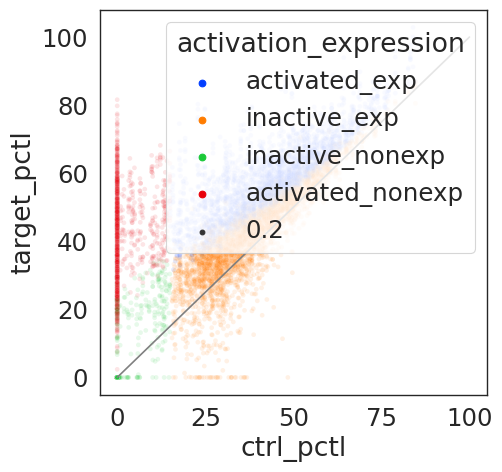

In [263]:
#single cell-type rpe1
plt.figure(figsize=(5, 5))

sns.scatterplot(data=rpe1_a_analysis, x='ctrl_pctl', y='target_pctl',
                 size=0.2, alpha=0.1, 
                hue='activation_expression',  palette = 'bright')


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

/tmp/ipykernel_714896/2901668850.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=rpe1_a_analysis, x='ctrl_pctl', y='target_pctl',


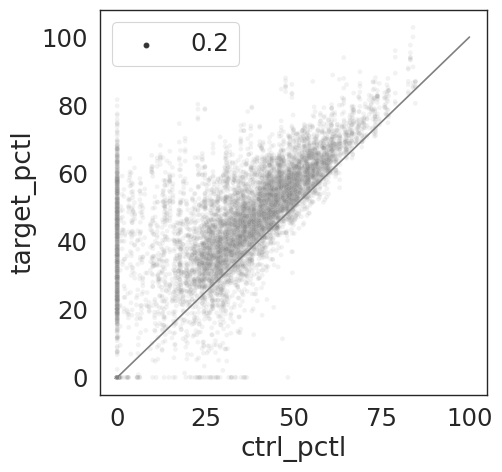

In [264]:
#single cell-type rpe1
plt.figure(figsize=(5, 5))

sns.scatterplot(data=rpe1_a_analysis, x='ctrl_pctl', y='target_pctl',
                 size=0.2, alpha=0.1, 
                color='grey',  palette = 'bright')


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

<Figure size 500x500 with 0 Axes>

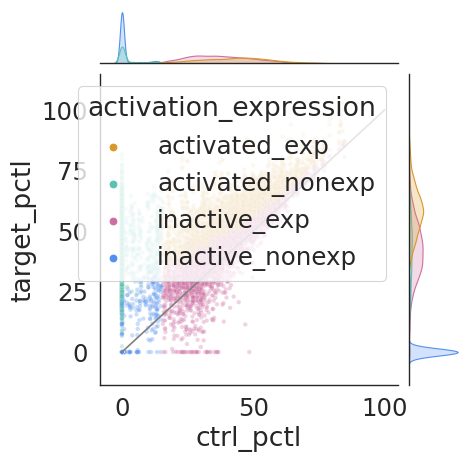

<Figure size 500x500 with 0 Axes>

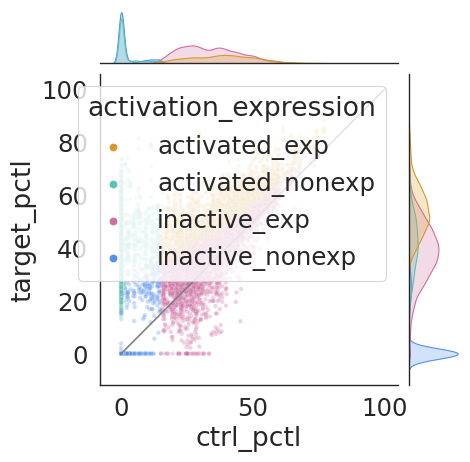

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming rpe1_a_analysis and fibro_primary are defined

# Define your color palette
colors = ['#D99828', '#5AC2B0','#ce6da1', '#528FF0']

# Explicitly define the order of categories for 'activation_expression'
hue_order = sorted(rpe1_a_analysis['activation_expression'].unique())

# First Plot
plt.figure(figsize=(5, 5))
sns.jointplot(data=rpe1_a_analysis, x='ctrl_pctl', y='target_pctl',
              alpha=0.3, hue='activation_expression', height=5, s = 10,
              palette=colors, hue_order=hue_order)
plt.plot(np.linspace(0, 100), np.linspace(0, 100), color='gray')
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240406_rpe1_guide_classification_categories.svg')

plt.show()  # Show the first plot before creating the second to avoid overlap

# Second Plot
plt.figure(figsize=(5, 5))
sns.jointplot(data=fibro_primary, x='ctrl_pctl', y='target_pctl',
              alpha=0.3, hue='activation_expression', height=5, s = 10,
              palette=colors, hue_order=hue_order)
plt.plot(np.linspace(0, 100), np.linspace(0, 100), color='gray')
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240406_fibro_guide_classification_categories.svg')

plt.show()  # Show the second plot


<Figure size 500x500 with 0 Axes>

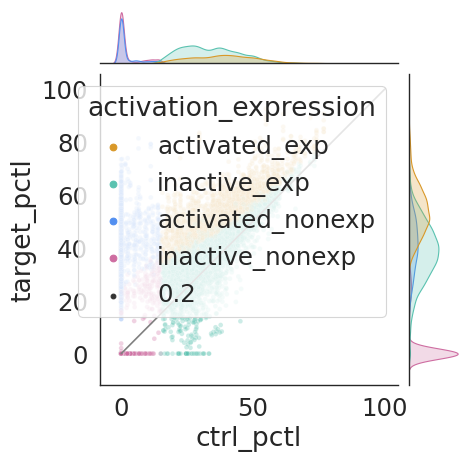

In [266]:
plt.figure(figsize=(5, 5))

# Define your color palette
colors = [#'#864D9E', '#376ADC', '#AE5981', 
          '#D99828','#5AC2B0', '#528FF0', '#ce6da1']


sns.jointplot(data=fibro_primary, x='ctrl_pctl', y='target_pctl',
                 size=0.2, alpha=0.3, hue='activation_expression', 
              height = 5,
              palette = colors
             )


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

<Figure size 500x500 with 0 Axes>

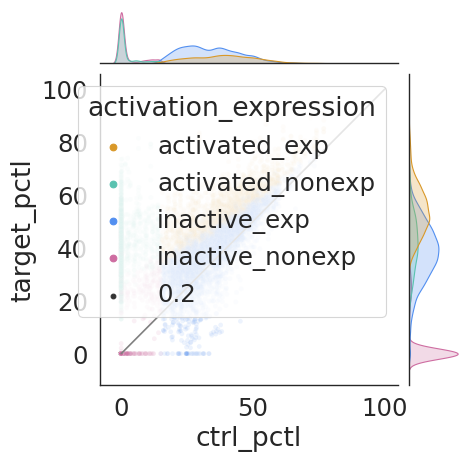

In [267]:
plt.figure(figsize=(5, 5))

sns.jointplot(data=fibro_primary.sort_values('activation_expression'), x='ctrl_pctl', y='target_pctl',
                 size=0.2, alpha=0.1, hue='activation_expression',  
              height = 5,
              palette = colors
             )


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

# Cell type comparison of Active Guides

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

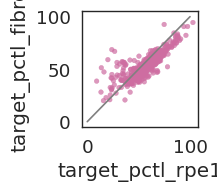

In [268]:
#comparing on target expression in the two cell type
#some guides well correlated, some only active in 1

## Color Palette

#1. #864D9E - A deep purplish hue.
#2. #376ADC - A softened medium blue with reduced saturation.
#3. #AE5981 - A muted pinkish-purple.
#4. #5AC2B0 - A teal or turquoise-like color.
#5. #D99828 - A golden yellow.
#6. #528FF0 - A light blue shade.

# Set the style and context for publication-quality figures
sns.set(style="white", context="paper", font_scale=1.5)


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'



plt.figure(figsize=(1.5, 1.5))

sns.scatterplot(data=guides_merged.query('primary_target == True')[guides_merged.top_guide_fibro&guides_merged.top_guide_rpe1],
                x='target_pctl_rpe1', y='target_pctl_fibro',
                size=0.1, legend = False, color = '#CE6DA1',
                edgecolor = None,
              alpha=0.7,# bins = 70,
             # hue='best_guide_fibro', #kind = 'hist'
               )

# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/240406comparison_of_top_guides_across_celltypes_noedgecolor.svg')

# Show the plot
plt.show()

In [269]:
import pandas as pd
import numpy as np


# Function to determine the category
def categorize_guide(row):
    if pd.isna(row['is_activated_rpe1']) or pd.isna(row['is_activated_fibro']):
        return 'NaN'
    elif row['is_activated_rpe1'] and row['is_activated_fibro']:
#         if row['top_guide_fibro'] and row['top_guide_rpe1']:
#             return 'Top Both'
#         else:
        return 'Both'
    elif row['is_activated_rpe1']:
        return 'RPE1'
    elif row['is_activated_fibro']:
        return 'Fibro'
    else:
        return 'Inactive in Both'

# Applying the function to each row
guides_merged['guide_category'] = guides_merged.apply(categorize_guide , axis=1)


<Figure size 1000x1000 with 0 Axes>

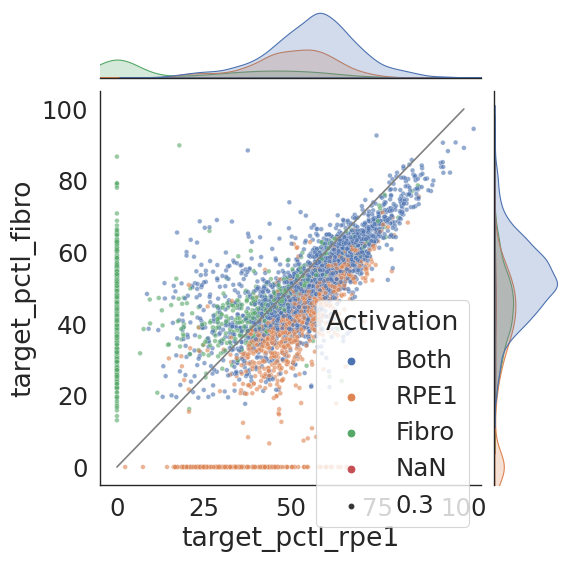

In [270]:

# Set the style and context for publication-quality figures
sns.set(style="white", context="paper", font_scale = 2)


#1. #864D9E - A deep purplish hue.
#2. #376ADC - A softened medium blue with reduced saturation.
#3. #AE5981 - A muted pinkish-purple.
#4. #5AC2B0 - A teal or turquoise-like color.
#5. #D99828 - A golden yellow.
#6. #528FF0 - A light blue shade.
#7. #ce6da1 - A pinkish red 



plt.figure(figsize=(10, 10))

sns.jointplot(data=guides_merged[(guides_merged.is_activated_fibro|guides_merged.is_activated_rpe1)&~(guides_merged.guide_category == 'Category: NaN')],
                x='target_pctl_rpe1', y='target_pctl_fibro',
                size=0.3, 
              alpha = 0.6,
              #alpha=0.7, bins = 70,
              hue='guide_category',#kind = 'hist'
               )

plt.xlim(-5, 105)
plt.ylim(-5, 105)
# Moving the legend to the right of the figure
plt.legend(title='Activation', bbox_to_anchor=(1, 0.5), loc='upper right')


# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

#plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/comparison_of_all_active_guides_across_cell_types.pdf', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

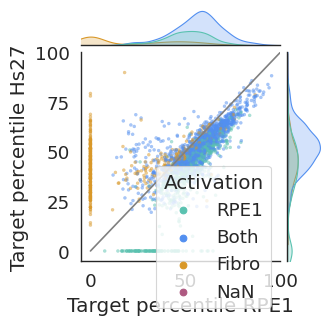

In [271]:
# Set the style and context for publication-quality figures
sns.set(style="white", context="paper", font_scale=1.5)

# Define your color palette
color_palette = {
    'Both': '#528FF0',  # Assuming 'Category1' as a placeholder, replace it with your actual category names
    'RPE1': '#5AC2B0',
    'Fibro': '#D99828',
    'NaN': '#AE5981',
    'Category5': '#D99828',
    'Category6': '#528FF0',
}

# Filter the data
filtered_data = guides_merged[(guides_merged.is_activated_fibro | guides_merged.is_activated_rpe1) & ~(guides_merged.guide_category == 'Category: NaN')]

# Assuming `filtered_data` is your DataFrame and it includes a 'guide_category' column

# Define subsampling fractions for each category
subsampling_fractions = {
    'Both': 1.0,  # More aggressive downsampling for 'Both'
    'RPE1': 1.0,
    'Fibro': 1.0,
    # Add other categories and their desired subsampling fractions as needed
}

# Subsample each category separately
sampled_dfs = []
for category, fraction in subsampling_fractions.items():
    category_df = filtered_data[filtered_data['guide_category'] == category]
    sampled_df = category_df.sample(frac=fraction, random_state=42) if fraction < 1 else category_df
    sampled_dfs.append(sampled_df)


sampled_data = filtered_data.sample(frac=0.5, random_state=42)


sns.jointplot(
    data=sampled_data,
    x='target_pctl_rpe1', y='target_pctl_fibro',
    height=3.5,  # Updated parameter from size to height
    alpha=0.5,
    s= 5,
    edgecolor = None,
    hue='guide_category',
    palette=color_palette,  # Using the defined color palette
)

plt.xlim(-5, 100)
plt.ylim(-5, 100)
# Moving the legend to the right of the figure
plt.legend(title='Activation', bbox_to_anchor=(1, 0.5), loc='upper right')

plt.xlabel('Target percentile RPE1')
plt.ylabel('Target percentile Hs27')

# Add a 1:1 line
plt.plot(np.linspace(0, 100), np.linspace(0, 100), color='gray')

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/comparison_of_all_active_guides_across_cell_types_sampled.svgz')

# Show the plot
plt.show()

TypeError: histplot() got multiple values for keyword argument 'x'

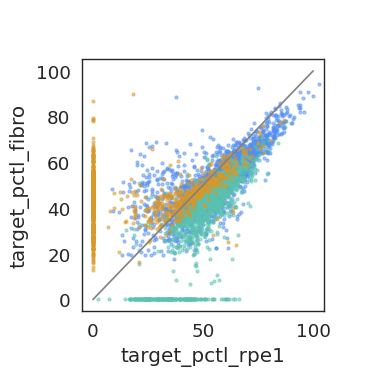

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming guides_merged is your DataFrame and is already loaded

# Set the style and context for publication-quality figures
sns.set(style="white", context="paper", font_scale=1.5)

# Define your color palette
color_palette = {
    'Both': '#528FF0',  # Assuming 'Category1' as a placeholder, replace it with your actual category names
    'RPE1': '#5AC2B0',
    'Fibro': '#D99828',
    'NaN': '#5AC2B0',
    'Category5': '#D99828',
    'Category6': '#528FF0',
}

# Filter the data
filtered_data = guides_merged[(guides_merged.is_activated_fibro | guides_merged.is_activated_rpe1) & ~(guides_merged.guide_category == 'Category: NaN')]

# Initialize a JointGrid but don't plot the scatter yet
g = sns.JointGrid(data=filtered_data, x='target_pctl_rpe1', y='target_pctl_fibro', hue='guide_category', palette=color_palette, height=4, space=0)

# Plot each category with matched edge and face colors
for category, color in color_palette.items():
    data = filtered_data[filtered_data["guide_category"] == category]
    g.ax_joint.scatter(data['target_pctl_rpe1'], data['target_pctl_fibro'], color=color, edgecolor=color, alpha=0.5, s=5)

# Set limits
g.ax_joint.set_xlim(-5, 105)
g.ax_joint.set_ylim(-5, 105)

# Add a 1:1 line
g.ax_joint.plot(np.linspace(0, 100), np.linspace(0, 100), color='gray')


# Plot the marginal distributions
# Using the same data without hue because seaborn does not support hue in plot_marginals yet
g.plot_marginals(sns.histplot, data=filtered_data, x='target_pctl_rpe1', y='target_pctl_fibro', color='gray', edgecolor='none')


# Add legend manually if needed
g.ax_joint.legend(handles=g.ax_joint.collections, labels=color_palette.keys(), title='Activation', bbox_to_anchor=(1.05, 1), loc=2)

# Save the plot if needed
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/comparison_of_all_active_guides_across_cell_types_edge_color_fix.svgz')

# Display the plot
plt.show()


# Collapse to target level summary of activation across cell types

In [346]:
target_agg = guides_merged.query('primary_target == True').groupby('target_gene').agg({'protospacer': 'count',
                                        'is_activated_fibro': 'sum',
                                          'is_activated_rpe1':'sum',
                                         'bad_seed': 'sum'}
                                        )

#target_agg['bad_seed_prop'] = target_agg.bad_seed/target_agg.protospacer

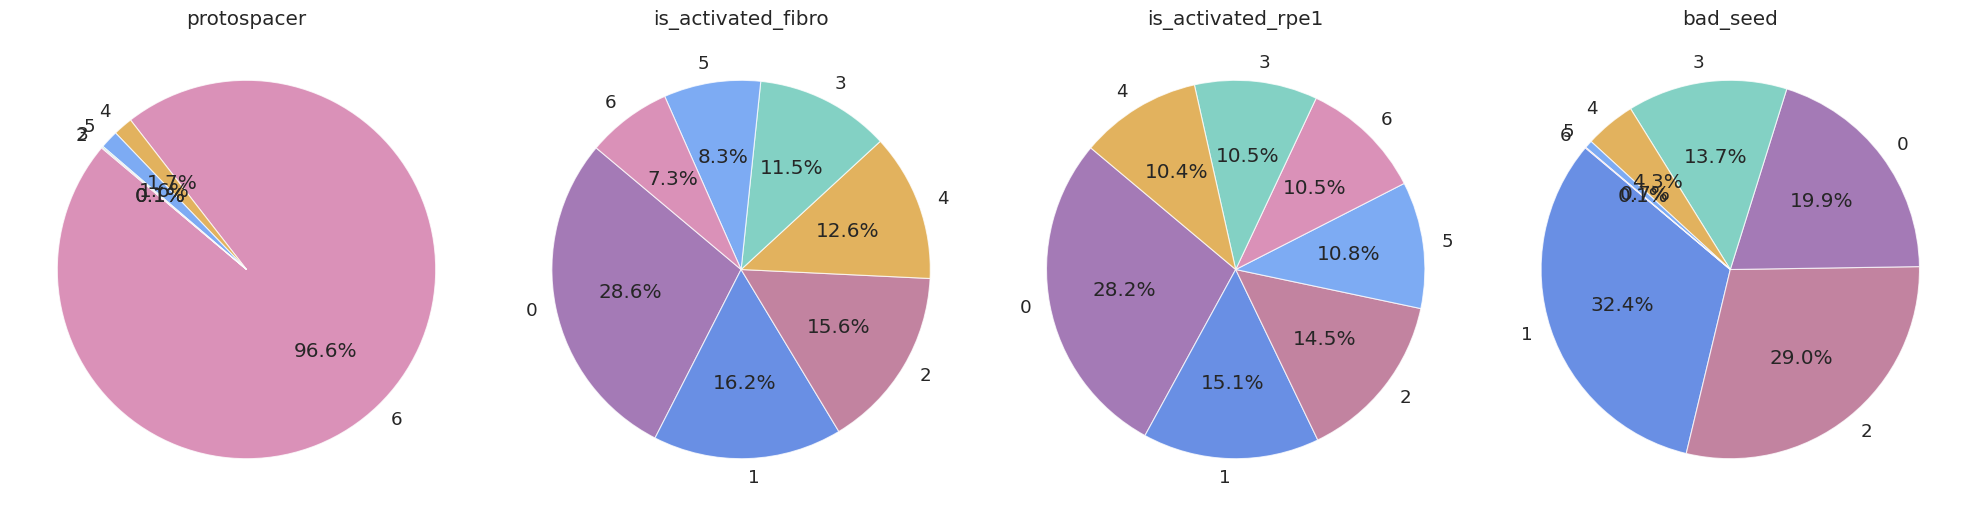

In [274]:
import matplotlib.pyplot as plt

# Assuming 'target_agg' is your DataFrame

# Define your color map
colors = ['#864D9E', '#376ADC', '#AE5981', '#5AC2B0', '#D99828', '#528FF0', '#ce6da1']

# Map categories to colors
all_categories = pd.unique(target_agg.values.ravel('K'))
all_categories.sort()
category_color_map = {category: colors[i % len(colors)] for i, category in enumerate(all_categories)}

# Number of rows and columns
n_rows, n_cols = target_agg.shape

# Create a figure and axes for the pie charts
fig, axs = plt.subplots(1, n_cols, figsize=(n_cols * 5, 6))

# Ensure axs is an array for consistent indexing when n_cols is 1
axs = np.array(axs).reshape(-1)

# Set the opacity level
opacity = 0.75  # Adjust opacity here (0.0 to 1.0)

# Iterate over each column to create a pie chart
for i, column in enumerate(target_agg.columns):
    data = target_agg[column].value_counts()
    pie_colors = [category_color_map[category] for category in data.index]
    
    axs[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=pie_colors,
               wedgeprops={'alpha': opacity})  # Set opacity for pie slices

    axs[i].set_title(column)

# Adjust layout
plt.tight_layout()

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/number_of_guides_per_target_and_bad_seeds_agg.svg')

# Show the plot
plt.show()

/tmp/ipykernel_714896/3824996915.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_agg.bad_seed)


<AxesSubplot: xlabel='bad_seed', ylabel='Density'>

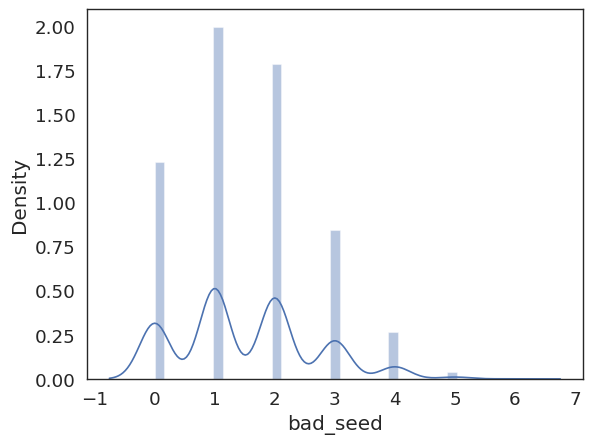

In [276]:
sns.distplot(target_agg.bad_seed)

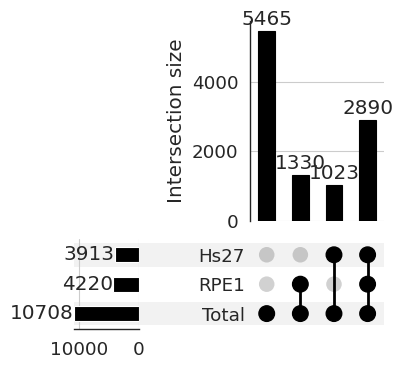

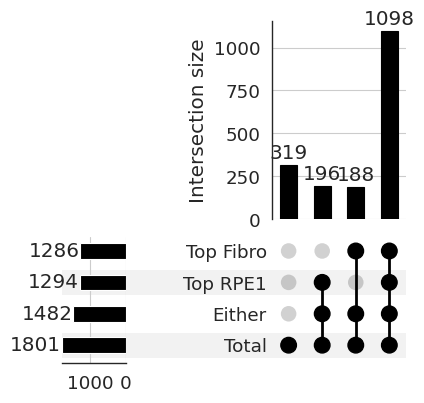

In [280]:
active_in_fibro = guides_merged.query('primary_target == True')[guides_merged.is_activated_fibro == True].index

top_in_fibro = guides_merged.query('primary_target == True')[(guides_merged.top_guide_fibro == True)].index.get_level_values(1)

active_in_rpe1 = guides_merged.query('primary_target == True')[guides_merged.is_activated_rpe1 == True].index

top_in_rpe1 = guides_merged.query('primary_target == True')[guides_merged.top_guide_rpe1 == True].index.get_level_values(1)


active_in_both = guides_merged.query('primary_target == True')[guides_merged.guide_category == 'Both'].index
inactive_in_both = guides_merged.query('primary_target == True')[guides_merged.guide_category == 'Inactive in Both'].index
total_guides = guides_merged.query('primary_target == True').index

top_either = guides_merged.query('primary_target == True')[(guides_merged.top_guide_fibro == True)|(guides_merged.top_guide_rpe1 == True)].index.get_level_values(1)
total_targets =  guides_merged.query('primary_target == True').index.get_level_values(1)


from upsetplot import from_contents
guides_upset = from_contents({'Total': total_guides, 
                            "Hs27": active_in_fibro, 
                              "RPE1": active_in_rpe1})
                              
top_upset = from_contents({  'Top Fibro': top_in_fibro.drop_duplicates(),
                             'Top RPE1': top_in_rpe1.drop_duplicates(),
                             'Either': top_either.drop_duplicates(),
                             'Total': total_targets.drop_duplicates()
                          })

from upsetplot import UpSet
ax_dict = UpSet(guides_upset, subset_size="count", show_counts=True).plot()
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_guide_activity_upset_plot.svg')


ax_dict = UpSet(top_upset, subset_size="count", show_counts=True).plot()
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240418_target_activity_upset_plot.svg')


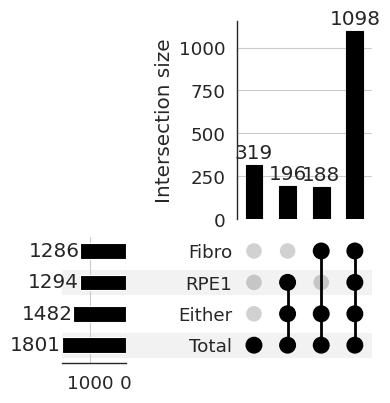

In [278]:
targets_total = target_agg.index.to_list()
targets_fibro = target_agg.query('is_activated_fibro > 0').index.to_list()
targets_rpe1 = target_agg.query('is_activated_rpe1 > 0').index.to_list()
targets_either = target_agg.query('(is_activated_rpe1 > 0)|(is_activated_fibro > 0)').index.to_list()

target_upset = from_contents({ 'Total': targets_total, 'Fibro': targets_fibro, 'Either': targets_either,
                             'RPE1': targets_rpe1})
ax_dict = UpSet(target_upset, subset_size="count", show_counts=True).plot()

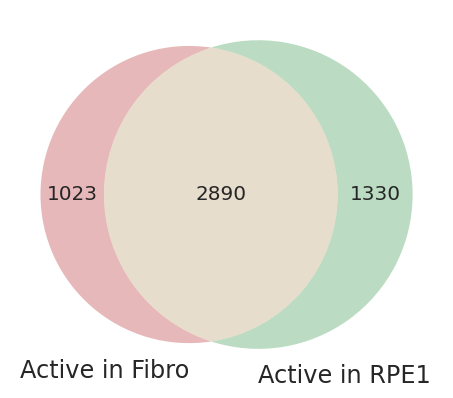

In [281]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Assuming active_in_fibro and active_in_rpe1 are sets or can be converted to sets
# If they are pandas Index objects, they can be directly used in set operations

set_active_in_fibro = set(active_in_fibro)
set_active_in_rpe1 = set(active_in_rpe1)

# Create the Venn diagram for two sets
venn2([set_active_in_fibro, set_active_in_rpe1], ('Active in Fibro', 'Active in RPE1'))

# Display the plot
plt.show()

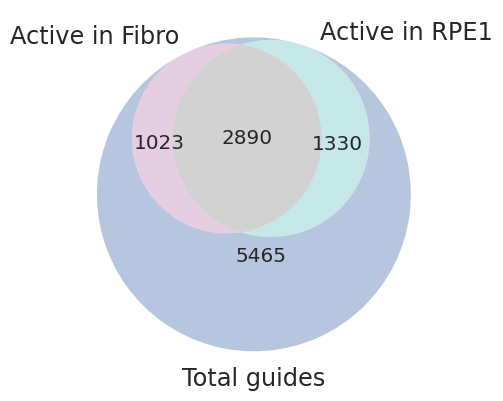

In [282]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Convert indices or lists to sets for Venn diagram plotting
set_active_in_fibro = set(active_in_fibro)
set_active_in_rpe1 = set(active_in_rpe1)
set_total_guides = set(total_guides)

# Create the Venn diagram for three sets
venn3([set_active_in_fibro, set_active_in_rpe1,  set_total_guides],
      ('Active in Fibro', 'Active in RPE1', 'Total guides'))


plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/guides_active_across_celltypes.svg')


# Display the plot
plt.show()


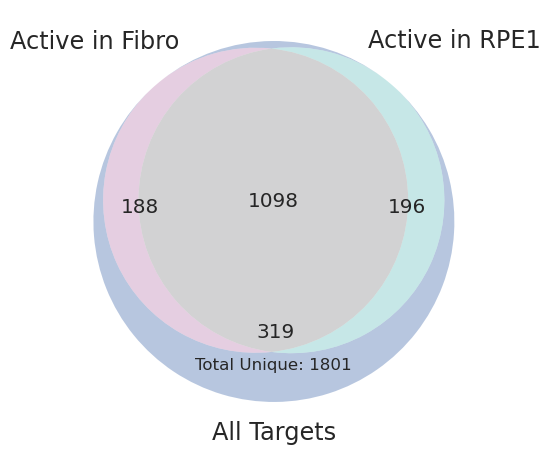

In [283]:
# Convert indices or lists to sets for Venn diagram plotting
set_targets_total = set(targets_total)
set_targets_fibro = set(targets_fibro)
set_targets_rpe1 = set(targets_rpe1)

# Calculate the total unique elements across all sets
total_unique = set_targets_total



# targets_total = target_agg.index.to_list()
# targets_fibro = target_agg.query('is_activated_fibro > 0').index.to_list()
# targets_rpe1 = target_agg.query('is_activated_rpe1 > 0').index.to_list()
# targets_either = target_agg.query('(is_activated_rpe1 > 0)|(is_activated_fibro > 0)').index.to_list()

# Create the Venn diagram for three sets
venn3([set_targets_fibro, set_targets_rpe1, set_targets_total],
      ('Active in Fibro', 'Active in RPE1', 'All Targets'))

# Display the total number on the diagram
plt.text(0, -0.5, f'Total Unique: {len(total_unique)}', fontsize=12, ha='center')

# Adjust layout
plt.tight_layout()

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/targets_activatevable_across_celltypes.svg')

# Display the plot
plt.show()

<AxesSubplot: xlabel='is_activated_fibro', ylabel='Count'>

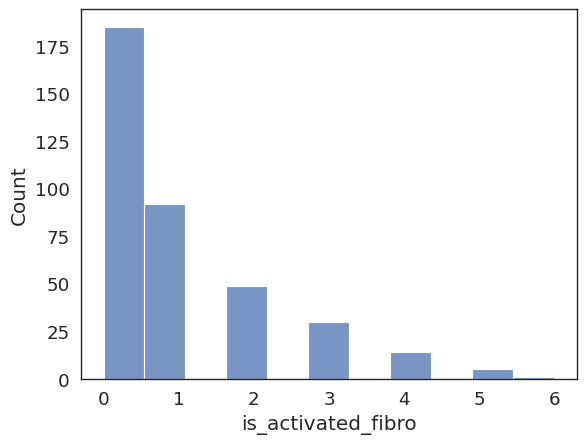

In [347]:
znf_genes = [
    'ZNF2', 'ZNF100', 'ZNF200', 'ZNF300', 'ZNF404', 'ZNF500', 'ZNF600', 'ZNF700', 'ZNF805', 'ZFP1',
    'AC010642.1', 'ZNF3', 'ZNF101', 'ZNF202', 'ZNF302', 'ZNF415', 'ZNF506', 'ZNF605', 'ZNF701', 'ZNF808',
    'ZFP2', 'AC073343.1', 'ZNF7', 'ZNF107', 'ZNF205', 'ZNF304', 'ZNF416', 'ZNF510', 'ZNF606', 'ZNF705A',
    'ZNF812', 'ZFP14', 'CTD-2192J16.20', 'ZNF8', 'ZNF112', 'ZNF208', 'ZNF311', 'ZNF417', 'ZNF514', 'ZNF607',
    'ZNF705B', 'ZNF813', 'ZFP28', 'HKR1', 'ZNF10', 'ZNF114', 'ZNF211', 'ZNF317', 'ZNF418', 'ZNF517',
    'ZNF610', 'ZNF705G', 'ZNF814', 'ZFP30', 'KRBOX4', 'ZNF12', 'ZNF117', 'ZNF212', 'ZNF320', 'ZNF419',
    'ZNF519', 'ZNF611', 'ZNF707', 'ZNF816', 'ZFP37', 'PRDM9', 'ZNF14', 'ZNF121', 'ZNF213', 'ZNF324',
    'ZNF420', 'ZNF525', 'ZNF613', 'ZNF708', 'ZNF823', 'ZFP57', 'RBAK', 'ZNF16', 'ZNF124', 'ZNF214',
    'ZNF324B', 'ZNF425', 'ZNF527', 'ZNF614', 'ZNF709', 'ZNF829', 'ZFP69', 'RP11-1396O13.13', 'ZNF17',
    'ZNF132', 'ZNF215', 'ZNF331', 'ZNF426', 'ZNF528', 'ZNF615', 'ZNF713', 'ZNF836', 'ZFP69B', 'ZIK1',
    'ZNF18', 'ZNF133', 'ZNF221', 'ZNF333', 'ZNF429', 'ZNF529', 'ZNF616', 'ZNF714', 'ZNF837', 'ZFP82',
    'ZIM2', 'ZNF19', 'ZNF134', 'ZNF222', 'ZNF334', 'ZNF430', 'ZNF530', 'ZNF619', 'ZNF716', 'ZNF841',
    'ZFP90', 'ZIM3', 'ZNF20', 'ZNF135', 'ZNF223', 'ZNF337', 'ZNF431', 'ZNF534', 'ZNF620', 'ZNF717',
    'ZNF844', 'ZFP92', 'ZKSCAN1', 'ZNF23', 'ZNF136', 'ZNF224', 'ZNF343', 'ZNF432', 'ZNF540', 'ZNF621',
    'ZNF720', 'ZNF845', 'ZKSCAN2', 'ZNF25', 'ZNF138', 'ZNF225', 'ZNF345', 'ZNF433', 'ZNF543', 'ZNF624',
    'ZNF721', 'ZNF846', 'ZKSCAN3', 'ZNF26', 'ZNF140', 'ZNF226', 'ZNF347', 'ZNF436', 'ZNF544', 'ZNF625',
    'ZNF724P', 'ZNF850', 'ZKSCAN4', 'ZNF28', 'ZNF141', 'ZNF227', 'ZNF350', 'ZNF439', 'ZNF546', 'ZNF625-ZNF20',
    'ZNF726', 'ZNF852', 'ZKSCAN5', 'ZNF30', 'ZNF154', 'ZNF229', 'ZNF354A', 'ZNF440', 'ZNF547', 'ZNF626',
    'ZNF727', 'ZNF860', 'ZKSCAN7', 'ZNF33A', 'ZNF155', 'ZNF230', 'ZNF354B', 'ZNF441', 'ZNF548', 'ZNF627',
    'ZNF728', 'ZNF878', 'ZKSCAN8', 'ZNF33B', 'ZNF157', 'ZNF233', 'ZNF354C', 'ZNF442', 'ZNF549', 'ZNF630',
    'ZNF729', 'ZNF879', 'ZSCAN4', 'ZNF34', 'ZNF160', 'ZNF234', 'ZNF382', 'ZNF443', 'ZNF550', 'ZNF641',
    'ZNF730', 'ZNF880', 'ZSCAN16', 'ZNF35', 'ZNF169', 'ZNF235', 'ZNF383', 'ZNF445', 'ZNF551', 'ZNF649',
    'ZNF732', 'ZNF891', 'ZSCAN18', 'ZNF37A', 'ZNF175', 'ZNF239', 'ZNF394', 'ZNF446', 'ZNF552', 'ZNF655',
    'ZNF736', 'ZSCAN21', 'ZNF41', 'ZNF177', 'ZNF248', 'ZNF398', 'ZNF454', 'ZNF554', 'ZNF660', 'ZNF737',
    'ZSCAN22', 'ZNF43', 'ZNF180', 'ZNF250', 'ZNF460', 'ZNF555', 'ZNF662', 'ZNF746', 'ZSCAN25', 'ZNF44',
    'ZNF181', 'ZNF251', 'ZNF461', 'ZNF556', 'ZNF665', 'ZNF747', 'ZSCAN29', 'ZNF45', 'ZNF182', 'ZNF253',
    'ZNF468', 'ZNF557', 'ZNF667', 'ZNF749', 'ZSCAN32', 'ZNF57', 'ZNF184', 'ZNF254', 'ZNF470', 'ZNF558',
    'ZNF669', 'ZNF763', 'ZNF66', 'ZNF189', 'ZNF256', 'ZNF471', 'ZNF559', 'ZNF670', 'ZNF764', 'ZNF69',
    'ZNF195', 'ZNF257', 'ZNF473', 'ZNF560', 'ZNF671', 'ZNF765', 'ZNF71', 'ZNF197', 'ZNF260', 'ZNF479',
    'ZNF561', 'ZNF674', 'ZNF766', 'ZNF74', 'ZNF263', 'ZNF480', 'ZNF562', 'ZNF675', 'ZNF768', 'ZNF75A',
    'ZNF264', 'ZNF483', 'ZNF563', 'ZNF676', 'ZNF772', 'ZNF75D', 'ZNF266', 'ZNF484', 'ZNF564', 'ZNF677',
    'ZNF773', 'ZNF77', 'ZNF267', 'ZNF485', 'ZNF565', 'ZNF678', 'ZNF776', 'ZNF79', 'ZNF268', 'ZNF486',
    'ZNF566', 'ZNF679', 'ZNF777', 'ZNF80', 'ZNF273', 'ZNF487', 'ZNF567', 'ZNF680', 'ZNF778', 'ZNF81',
    'ZNF274', 'ZNF490', 'ZNF568', 'ZNF681', 'ZNF780A', 'ZNF83', 'ZNF275', 'ZNF491', 'ZNF569', 'ZNF682',
    'ZNF780B', 'ZNF84', 'ZNF282', 'ZNF492', 'ZNF570', 'ZNF684', 'ZNF781', 'ZNF85', 'ZNF283', 'ZNF493',
    'ZNF571', 'ZNF688', 'ZNF782', 'ZNF90', 'ZNF284', 'ZNF496', 'ZNF573', 'ZNF689', 'ZNF783', 'ZNF91',
    'ZNF285', 'ZNF497', 'ZNF577', 'ZNF695', 'ZNF785', 'ZNF92', 'ZNF286A', 'ZNF578', 'ZNF699', 'ZNF786',
    'ZNF93', 'ZNF286B', 'ZNF582', 'ZNF788', 'ZNF98', 'ZNF287', 'ZNF583', 'ZNF789', 'ZNF99', 'ZNF584',
    'ZNF790', 'ZNF585A', 'ZNF791', 'ZNF585B', 'ZNF792', 'ZNF586', 'ZNF793', 'ZNF587', 'ZNF799', 'ZNF587B',
    'ZNF589', 'ZNF596', 'ZNF597', 'ZNF599'
]


sns.histplot(target_agg[target_agg.index.isin(znf_genes)].is_activated_fibro.astype('int'))

In [348]:
len(znf_genes)

393

<AxesSubplot: xlabel='is_activated_rpe1', ylabel='Count'>

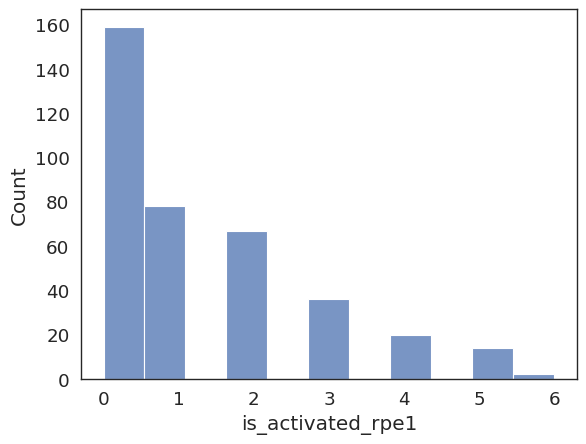

In [349]:
sns.histplot(target_agg[target_agg.index.isin(znf_genes)].is_activated_rpe1.astype('int'))#.describe()

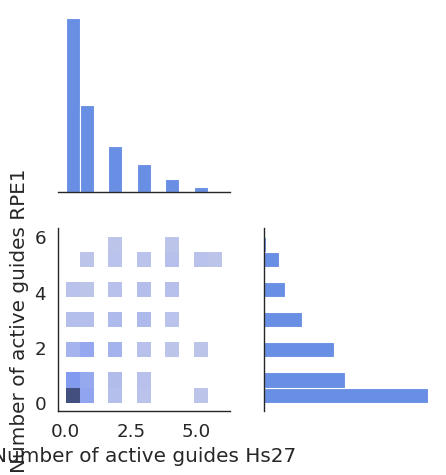

In [369]:
sns.jointplot(x = target_agg[target_agg.index.isin(znf_genes)].is_activated_fibro.astype('int'), 
               y = target_agg[target_agg.index.isin(znf_genes)].is_activated_rpe1.astype('int'),
              color = '#376ADC',
             kind = 'hist', height = 5, ratio = 1)

plt.xlabel('Number of active guides Hs27')
plt.ylabel('Number of active guides RPE1')

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240419_znfs_are_not_activated.svg')

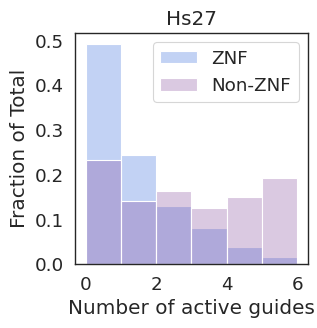

In [370]:
plt.figure(figsize = (3,3))

sns.histplot(target_agg[target_agg.index.isin(znf_genes)].is_activated_fibro.astype('int'), bins = 6, stat = 'density', common_norm=False, label="ZNF", alpha=0.3, color = '#376ADC')
sns.histplot(target_agg[~target_agg.index.isin(znf_genes)].is_activated_fibro.astype('int'), bins = 6, stat = 'density', common_norm=False, label="Non-ZNF", alpha=0.3, color = '#864D9E')

plt.title('Hs27')
plt.xlabel('Number of active guides')
plt.ylabel('Fraction of Total')
plt.legend()

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240419_znf_targets_vs_other_hs27.svg')

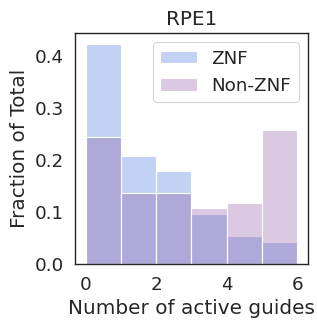

In [371]:
plt.figure(figsize = (3,3))

sns.histplot(target_agg[target_agg.index.isin(znf_genes)].is_activated_rpe1.astype('int'), bins = 6, stat = 'density', common_norm=False, label="ZNF", alpha=0.3, color = '#376ADC')
sns.histplot(target_agg[~target_agg.index.isin(znf_genes)].is_activated_rpe1.astype('int'), bins = 6, stat = 'density', common_norm=False, label="Non-ZNF", alpha=0.3, color = '#864D9E')

plt.title('RPE1')
plt.xlabel('Number of active guides')
plt.ylabel('Fraction of Total')
plt.legend()

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240419_znf_targets_vs_other_RPE1.svg')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/s

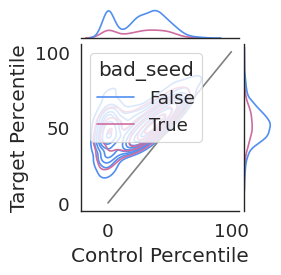

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_context('paper', font_scale = 1.5)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

# Define your color palette
colors = ['#528FF0', '#ce6da1','#D99828','#5AC2B0', '#D99828', '#528FF0', '#ce6da1']  # Example palette

# Assuming guides_merged is your DataFrame and it's already defined
# sns.jointplot call with the color palette applied
sns.jointplot(data=guides_merged[(guides_merged.primary_target) & (guides_merged.top_guide_fibro)],
              height = 3,
              s= 3,
              x='ctrl_pctl_fibro', y='target_pctl_fibro', hue='bad_seed',
              alpha=1, kind='kde', 
              #bins=50, 
              palette=colors,
            )


# plt.xlim(-5, 100)
# plt.ylim(-5, 100)
# Moving the legend to the right of the figure
#plt.legend(title='Activation', bbox_to_anchor=(1, 0.5), loc='upper right')

plt.xlabel('Control Percentile')
plt.ylabel('Target Percentile')

# Add a 1:1 line
plt.plot(np.linspace(0, 100), np.linspace(0, 100), color='gray')



plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240406_bad_seeds_vs_good_seeds_on_target.pdf')
plt.show()

In [93]:
# import matplotlib.pyplot as pl

In [673]:
sns.jointplot(data = guides_merged[guides_merged.primary_target & guides_merged.top_guide_fibro] , y = 'target_pctl_fibro', x = 'ctrl_pctl_fibro',hue = 'bad_seed' ,
             alpha = 0.9, #size = 0.1
             # kind = 'hist', bins = 50
             )

plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

x

In [372]:
target_agg['no_target_activation_fibro'] = False
target_agg.loc[target_agg.query('is_activated_fibro == 0 & is_activated_rpe1 > 0').index, 'no_target_activation_fibro']= True

target_agg['only_target_activation_fibro'] = False
target_agg.loc[target_agg.query('is_activated_fibro > 0 & is_activated_rpe1 == 0').index, 'only_target_activation_fibro']= True


In [373]:
target_agg['no_target_activation_rpe1'] = False
target_agg.loc[target_agg.query('is_activated_rpe1 == 0 & is_activated_fibro > 0').index, 'no_target_activation_rpe1']= True


target_agg['only_target_activation_rpe1'] = False
target_agg.loc[target_agg.query('is_activated_rpe1 > 0 & is_activated_fibro == 0').index, 'only_target_activation_rpe1']= True


In [374]:
target_agg.rename(columns = {'protospacer': 'guides_in_lib',
                            'is_activated_fibro':'active_guide_count_fibro', 
                             'is_activated_rpe1':'active_guide_count_rpe1',
                             'bad_seed': 'bad_seed_count'}, inplace = True)

In [376]:
difference = target_agg.only_target_activation_fibro != target_agg.no_target_activation_rpe1 

target_agg[difference]

,guides_in_lib,active_guide_count_fibro,active_guide_count_rpe1,bad_seed_count,no_target_activation_fibro,only_target_activation_fibro,no_target_activation_rpe1,only_target_activation_rpe1
target_gene,,,,,,,,


In [386]:
guides_merged = guides_merged.merge(target_agg, left_on = 'target_gene', right_index = True)

guides_merged.to_csv('/data/norman/southark/tfs_standardized/20240329_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef_activity_counts.csv')

# Comparison of single-cells to regressed coefs

In [420]:
#supplementary information showing regressions perform better than single cell analysis
#for on target activation

# Analysis of direct guide activation vs. downstream gene activation

In [805]:
guides_merged[~guides_merged['bad_seed']]

,,target_gene,ctrl_pctl_fibro,target_pctl_fibro,pctl_change_fibro,pctl_fc_fibro,pctl_log2fc_fibro,adj_p_fibro,ctrl_coef_fibro,ctrl_abs_fibro,target_coef_fibro,...,expressed_cat_rpe1,category_rpe1,protospacer,bad_seed,seed_matches,good_guide_fibro,good_guide_rpe1,best_guide_fibro,best_guide_rpe1,guide_category
guide_identity,gene_name,,,,,,,,,,,,,,,,,,,,,
AATF_GCGCAGAAGGTTGAAGGGAT,ENSG00000275700,AATF,40.901,56.899427,15.998427,1.391150,0.476278,2.192302e-27,0.147171,0.147171,0.888691,...,Expressed,Inactive_Expressed,GCGCAGAAGGTTGAAGGGAT,False,[],True,True,False,False,Both
AATF_GGAAGCGCGCAGAAGGTTGA,ENSG00000275700,AATF,40.901,62.571534,21.670534,1.529829,0.613370,1.026817e-08,0.147171,0.147171,1.921923,...,Expressed,Inactive_Expressed,GGAAGCGCGCAGAAGGTTGA,False,[],True,True,True,True,Both
AATF_GGAAGGGATTGGAGCCGTAT,ENSG00000275700,AATF,40.901,55.581004,14.680004,1.358916,0.442456,4.503703e-28,0.147171,0.147171,0.734871,...,Expressed,Inactive_Expressed,GGAAGGGATTGGAGCCGTAT,False,[],True,True,False,False,Both
AATF_GTGAAGGGATTGGAGCCGTA,ENSG00000275700,AATF,40.901,51.025967,10.124967,1.247548,0.319095,3.859940e-03,0.147171,0.147171,0.358873,...,Expressed,Inactive_Expressed,GTGAAGGGATTGGAGCCGTA,False,[],True,True,False,False,Both
ABL1_GCCGCGCCCGTCCGCACCCA,ENSG00000097007,ABL1,39.200,47.262795,8.062795,1.205684,0.269851,1.775072e-01,0.119599,0.119599,0.200169,...,Expressed,Inactive_Expressed,GCCGCGCCCGTCCGCACCCA,False,[],False,True,False,False,RPE1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDB_GGAGCGGCGCGAATCCCGCG,ENSG00000198455,ZXDB,19.443,10.795757,-8.647243,0.555252,-0.848787,9.999976e-01,0.010743,0.010743,-0.007002,...,Expressed,Inactive_Expressed,GGAGCGGCGCGAATCCCGCG,False,[],False,False,False,False,Inactive in Both
ZXDC_GCAAGCCCCGGCGTAGAGTC,ENSG00000070476,ZXDC,29.162,28.651169,-0.510831,0.982483,-0.025496,9.999962e-01,0.035157,0.035157,-0.002126,...,Expressed,Inactive_Expressed,GCAAGCCCCGGCGTAGAGTC,False,[],False,False,False,False,Inactive in Both
ZXDC_GGGAGCGCCGGCACCTACGA,ENSG00000070476,ZXDC,29.162,36.037601,6.875601,1.235773,0.305413,9.999974e-01,0.035157,0.035157,0.046165,...,Expressed,Inactive_Expressed,GGGAGCGCCGGCACCTACGA,False,[],False,True,False,True,RPE1


In [150]:
filtered_guides_rpe1 = guides_merged[~(guides_merged.seed_driven_fibro|guides_merged.seed_driven_rpe1|guides_merged.bad_seed)
              &(guides_merged.is_activated_fibro)].index.get_level_values(0)

filtered_guides_fibro = guides_merged[~(guides_merged.seed_driven_fibro|guides_merged.seed_driven_rpe1|guides_merged.bad_seed)
              &(guides_merged.is_activated_rpe1)].index.get_level_values(0)

In [151]:
import numpy as np
import pandas as pd

def float_to_filename(value):
    return f"fdr_{str(value).replace('.', '')}"


def analyze_cell_population(cell_population, fdr_threshold=0.05, filtered_guides = None, dataset = None):
    # Access all_guides_percentiles_df from the cell_population's normalized_matrix
    all_guides_percentiles_df = cell_population.normalized_matrix['pctl_expr']

    adj_p = cell_population.normalized_matrix['adj_p']
    
    # Drop NA values and ensure unique target_gene_ids
    targets_series = cell_population.cells.target_gene_id.dropna().unique()

    # Filter out target_gene_ids not present in all_guides_percentiles_df
    valid_targets = [target for target in targets_series if target in adj_p.columns]
    
    # Now use only valid_targets to mask the DataFrame
    masked_df = all_guides_percentiles_df[valid_targets]
    
    genes = masked_df.columns.to_numpy()

    for guide, target_gene in cell_population.cells['target_gene_id'].iteritems():
        match_mask = genes == target_gene
        masked_df.loc[guide, match_mask] = np.nan

    # The rest of your analysis as before
    filtered_rows = [row for row in masked_df.index if 'off-target' not in row and row in adj_p.index]
    filtered_df = masked_df.loc[filtered_rows]

    existing_cols = [col for col in filtered_df.columns if col in adj_p.columns]
    existing_rows = [row for row in filtered_df.index if row in adj_p.index]
    adj_p_df = (cell_population.normalized_matrix['adj_p'].loc[existing_rows, existing_cols] < fdr_threshold)#.T
    adj_p_df.loc['control'] = False
    count_profile_df = (cell_population.normalized_matrix['count_profile'].loc[existing_rows, existing_cols] >= 3)#.T

    array1 = filtered_df.loc[existing_rows, existing_cols].values
    array2 = adj_p_df.values
    array3 = count_profile_df.values
    masked_array = np.where(array2, array1, np.nan)
    masked_array_count = np.where(array3, masked_array, np.nan)

    filtered_pval_df = pd.DataFrame(masked_array_count, index=existing_rows, columns=existing_cols)

        # Apply guide filtering if filtered_guides are provided
    if filtered_guides is not None and len(filtered_guides) > 0:
        filtered_pval_df = filtered_pval_df.loc[filtered_guides]
        filename = 'guide_seed_and_on_target_filtered'
        
    else:
        filename = 'all_guides'
    
    analysis_results = []
    for index, row in filtered_pval_df.T.iterrows():
        max_column_name = row.idxmax()
        max_value = row.max()
        mean_value = row.mean(skipna=True)
        p_val = 1  # Default to 1
        count_p = np.nan  # Default to NaN
        if max_column_name in cell_population.normalized_matrix['adj_p'].index and index in cell_population.normalized_matrix['adj_p'].columns:
            p_val = cell_population.normalized_matrix['adj_p'].loc[max_column_name, index]
        if max_column_name in cell_population.normalized_matrix['count_profile'].index and index in cell_population.normalized_matrix['count_profile'].columns:
            count_p = cell_population.normalized_matrix['count_profile'].loc[max_column_name, index]
        
        analysis_results.append((index, max_column_name, max_value, p_val, count_p, mean_value))
        
    max_values_df = pd.DataFrame(analysis_results, columns=['gene_name', 'guide_max','max_value', 'adj_p', 'count_profile', 'mean_value']).drop_duplicates().set_index('gene_name')
    max_values_df['control'] = masked_df.loc['control'].drop_duplicates()
    
    filtered_pval_df.loc['control'] = masked_df.loc['control']
    
    fdr_string = float_to_filename(fdr_threshold)
    
    filtered_pval_df.to_csv(f'{output_path}/{date}_{dataset}_{fdr_string}_tfs_change_by_other_guides_{filename}.csv')
    
    return max_values_df, filtered_pval_df

# Example usage
filtered_results_dict = {}
full_results_dict = {}
filtered_tf_matrix = {}
full_tf_matrix = {}
fdr_threshold = 0.05
for key, cell_pop in pctl_pops.items():
    
    if key == 'fibro_a':
        filtered_guides = filtered_guides_fibro
    elif key == 'rpe1_a':
        filtered_guides = filtered_guides_rpe1
    else:
        print('key does not match')
        
    filtered_results_dict[key],filtered_tf_matrix[key] = analyze_cell_population(cell_pop, fdr_threshold, filtered_guides, dataset = key)
    full_results_dict[key],full_tf_matrix[key] = analyze_cell_population(cell_pop, fdr_threshold,  dataset = key)
    

# At this point, analysis_results_dict contains the analysis DataFrame for each cell population key


/tmp/ipykernel_228071/2656184481.py:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for guide, target_gene in cell_population.cells['target_gene_id'].iteritems():
/tmp/ipykernel_228071/2656184481.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_df.loc[guide, match_mask] = np.nan
/tmp/ipykernel_228071/2656184481.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_df.loc[guide, match_mask] = np.nan
/tmp/ipykernel_228071/2656184481.py:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for gui

In [154]:
len(filtered_tf_matrix['rpe1_a'].reset_index().guide_identity.str.split('_').str[0].unique())

1096

In [155]:
len(filtered_tf_matrix['fibro_a'].reset_index().guide_identity.str.split('_').str[0].unique())

1114

In [156]:
counts_change_per_gene = filtered_tf_matrix['fibro_a'].describe().loc['count']

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

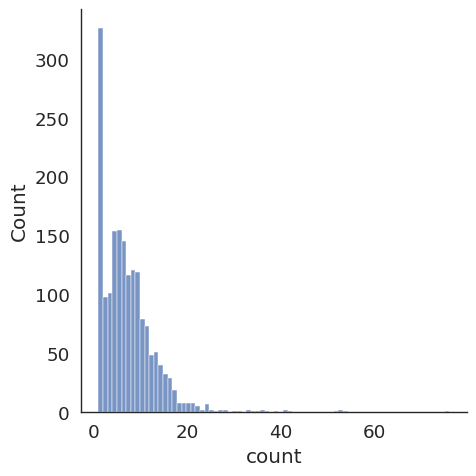

In [159]:
sns.displot(counts_change_per_gene)

In [165]:
top_guides_all_fibro = guides_merged[guides_merged.primary_target].reset_index().set_index('gene_name').sort_values('target_pctl_fibro', ascending = False).drop_duplicates('target_gene')
mean_guides_all_fibro = guides_merged[guides_merged.primary_target&guides_merged.is_activated_fibro].reset_index().groupby('gene_name').target_pctl_fibro.mean()

In [166]:
top_guides_all_fibro

,guide_identity,target_gene,ctrl_pctl_fibro,target_pctl_fibro,pctl_change_fibro,pctl_fc_fibro,pctl_log2fc_fibro,adj_p_fibro,ctrl_coef_fibro,ctrl_abs_fibro,...,protospacer,bad_seed,seed_matches,good_guide_fibro,good_guide_rpe1,best_guide_fibro,best_guide_rpe1,seed_driven_fibro,seed_driven_rpe1,guide_category
gene_name,,,,,,,,,,,,,,,,,,,,,
ENSG00000065978,YBX1_GCGGAGGCAGGAACGGTTGT,YBX1,71.746,94.453058,22.707058,1.316492,0.396699,0.000000e+00,6.335290,6.335290,...,GCGGAGGCAGGAACGGTTGT,False,[],True,True,True,True,False,False,Both
ENSG00000149968,MMP3_GTTGCCTTGCAAAATTGGGA,MMP3,54.925,92.594507,37.669507,1.685835,0.753464,0.000000e+00,0.814151,0.814151,...,GTTGCCTTGCAAAATTGGGA,True,[GGA],False,False,False,False,False,False,Both
ENSG00000243678,NME2_GCGCCAGGCAGAGATCGAGA,NME2,76.842,90.654096,13.812096,1.179747,0.238477,3.373649e-199,11.795601,11.795601,...,GCGCCAGGCAGAGATCGAGA,False,[],True,True,True,True,False,False,Both
ENSG00000060138,YBX3_GGACCCGCGCGCTCGCGTCC,YBX3,61.456,90.575545,29.119545,1.473828,0.559568,0.000000e+00,1.805784,1.805784,...,GGACCCGCGCGCTCGCGTCC,False,[],True,True,True,True,False,False,Both
ENSG00000117318,ID3_GATTGCAAACAGGCTTCCTC,ID3,74.089,84.470196,10.381196,1.140118,0.189183,1.700318e-09,8.430689,8.430689,...,GATTGCAAACAGGCTTCCTC,False,[],True,True,True,True,False,False,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000167800,TBX10_GACGCCTGGGCCCATCGATC,TBX10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,GACGCCTGGGCCCATCGATC,False,[],False,True,False,True,False,False,NaN
ENSG00000178928,TPRX1_GCCTTCTCATCTCCACCCAG,TPRX1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,GCCTTCTCATCTCCACCCAG,False,[],False,False,False,False,False,True,NaN
ENSG00000156925,ZIC3_GACGCCGCCGGGACTCTCGC,ZIC3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,GACGCCGCCGGGACTCTCGC,False,[],False,False,False,False,False,False,NaN


In [169]:
merged_tfs = filtered_results_dict['fibro_a'].merge(top_guides_all_fibro, left_index = True, right_index = True, how = 'outer')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/seaborn/axisgrid.py:1877: UserWarning: The pal

<Figure size 500x500 with 0 Axes>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

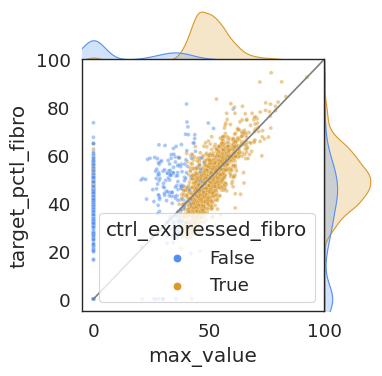

In [192]:
plt.figure(figsize=(5, 5))

colors = ['#528FF0','#D99828','#ce6da1','#5AC2B0',]


sns.jointplot(data = merged_tfs.fillna(0), x ='max_value' , y='target_pctl_fibro',
               hue = 'ctrl_expressed_fibro',
                 #size=0.2, 
              alpha=0.5,
               height=4, space=0,
               s= 8,
               palette=colors,
               )



# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

plt.xlim(-5,100)
plt.ylim(-5,100)

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/240604_max_activation_vs_max_downstream_effect_fibro.svg')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/lila/home/southark/notebooks/envs/barcode_fuzz/kms-analysis39/lib/python3.8/site-packages/seaborn/axisgrid.py:1877: UserWarning: The pal

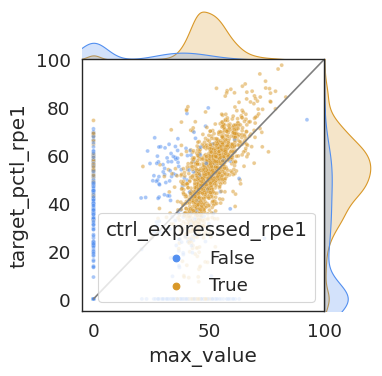

In [191]:
# Define your color map
colors = ['#528FF0','#D99828','#ce6da1','#5AC2B0',]


# Note: Adjusted 'size' to 's' for scatter plot size, as 'size' is not a valid argument for jointplot
# 'palette' is used instead of 'colors' to apply the color map
sns.jointplot(data=merged_tfs.fillna(0), x='max_value', y='target_pctl_rpe1',
               hue='ctrl_expressed_rpe1',
               alpha=0.5,
               height=4, space=0,
               s= 8,
               palette=colors,  # Using palette to apply the color map
               kind="scatter",  # Specify the kind of plot, scatter by default
               )

# Add a 1:1 line
plt.plot(np.linspace(0,100), np.linspace(0,100), color='gray')

plt.xlim(-5,100)
plt.ylim(-5,100)

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/240604_max_activation_vs_max_downstream_effect_rpe1.svg')